In [249]:
## Text Mining Project
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import re
import lyricsgenius
import time
import spacy
from gensim.corpora import Dictionary
from gensim.models import Phrases
from gensim.models import LdaModel
import logging
from gensim.models import CoherenceModel
from operator import itemgetter
from collections import Counter
import pyLDAvis.gensim
import pickle 
import pyLDAvis
import sklearn
from gensim.test.utils import datapath
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import euclidean_distances
import heapq
import math
from scipy.spatial import distance_matrix
from adjustText import adjust_text
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

In [4]:
all_artists = ['187 Strassenbande', 'AK Ausserkontrolle', 'Alligatoah', 'Apache 207', 'Azad', 'Azet', 'badmómzjay', 'Bausa', 'Beginner', 'Bonez MC', 'Bushido', 'Capital Bra', 'Casper', 'Celo & Abdi', 'Chakuza', 'Cro', 'Culcha Candela', 'CÉLINE', 'Dardan', 'Deichkind', 'Die Atzen', 'Die Fantastischen Vier', 'Eko Fresh', 'Eno', 'Farid Bang', 'Fero47', 'Fettes Brot', 'Fler', 'Freundeskreis', 'Genetikk', 'Gzuz', 'Haftbefehl', 'Jamule', 'Jan Delay', 'Joker Bra', 'Juju', 'K.I.Z', 'KC Rebell', 'Kay One', 'Kollegah', 'Kontra K', 'Kool Savas', 'Kraftklub', 'Loredana', 'Luciano', 'MERO', 'Marteria', 'Max Herre', 'MoTrip', 'Money Boy', 'Moses Pelham', 'Nimo', 'Olexesh', 'Peter Fox', 'Prinz Pi', 'RAF Camora', 'RIN', 'Rödelheim Hartreim Projekt', 'SSIO', 'SXTN', 'Sabrina Setlur', 'Samra', 'Samy Deluxe', 'Seeed', 'Shindy', 'Sido', 'Silla', 'Summer Cem', 'Tic Tac Toe', 'Trailerpark', 'Trettmann', 'Ufo361', 'Veysel', 'XATAR', 'Xavas', 'Yung Hurn', 'Zuna']

In [100]:
# Genius token - https://genius.com/api-clients
# Library - https://github.com/johnwmillr/LyricsGenius
token = "KbIhkIUKtt6IqQnUWh7KwZXWU8d-FduTSQfCnJWHQh97BVs07PisfSWIYs0uAwX6"
genius = lyricsgenius.Genius(token)

In [3]:
# Download the lyrics
for artist_name in all_artists:
    try:
        artist = genius.search_artist(artist_name, sort="title")
        artist.save_lyrics()
    except:
        time.sleep(300)
        artist = genius.search_artist(artist_name, sort="title")
        artist.save_lyrics()

In [6]:
# Store lyrics and relevant metadata in dataframe
all_songs = pd.DataFrame(columns = ['Title', 'Artist', 'Release', 'Lyrics'])

for artist_name in all_artists:
    print(artist_name)
    # Extract data from the json files
    with open(f'Lyrics_{artist_name.replace(" ", "").replace("&", "")}.json') as json_file:
        data = json.load(json_file)
        
        for song in data['songs']:
            title = song['title']
            release = song['release_date']
            lyrics_raw_raw = song['lyrics']
            # Exclude songs without lyrics or release date, songs that contain brackets () [] and commentaries
            if lyrics_raw_raw != None and release != None and not re.search(r' \(.*?\)| \[.*?\]', title) and 'Commentary' not in title:
                # Remove line breaks from lyrics
                lyrics_raw = lyrics_raw_raw.replace('\n', ' ')
                # Remove brackets from the lyrics, as they only contain meta info and calls e.g. [Hook], (yeah!)                
                lyrics = re.sub(r"[\[].*?[\]]|[\(].*?[\)]", "", lyrics_raw)
                # Filter lyrics with english parts by best effort
                if not re.search('(?=.* the )(?=.* you )(?=.* and )', lyrics):
                    new_song = {'Title': title, 'Artist': artist_name, 'Release': release, 'Lyrics': lyrics}
                    all_songs = all_songs.append(new_song, ignore_index=True)
                    
all_songs['Release'] = all_songs['Release'].map(lambda date: date[:-6])

187 Strassenbande
AK Ausserkontrolle
Alligatoah
Apache 207
Azad
Azet
badmómzjay
Bausa
Beginner
Bonez MC
Bushido
Capital Bra
Casper
Celo & Abdi
Chakuza
Cro
Culcha Candela
CÉLINE
Dardan
Deichkind
Die Atzen
Die Fantastischen Vier
Eko Fresh
Eno
Farid Bang
Fero47
Fettes Brot
Fler
Freundeskreis
Genetikk
Gzuz
Haftbefehl
Jamule
Jan Delay
Joker Bra
Juju
K.I.Z
KC Rebell
Kay One
Kollegah
Kontra K
Kool Savas
Kraftklub
Loredana
Luciano
MERO
Marteria
Max Herre
MoTrip
Money Boy
Moses Pelham
Nimo
Olexesh
Peter Fox
Prinz Pi
RAF Camora
RIN
Rödelheim Hartreim Projekt
SSIO
SXTN
Sabrina Setlur
Samra
Samy Deluxe
Seeed
Shindy
Sido
Silla
Summer Cem
Tic Tac Toe
Trailerpark
Trettmann
Ufo361
Veysel
XATAR
Xavas
Yung Hurn
Zuna


In [75]:
sw = list(en_stop_words) + manual_stop_words + list(nlp.Defaults.stop_words)

k = 5
vectorizer = TfidfVectorizer(stop_words=sw, use_idf=True)
lyrics = vectorizer.fit_transform(all_songs['Lyrics'])
kmeans = KMeans(n_clusters=k, n_init=20).fit(lyrics)

features = vectorizer.get_feature_names()

cluster_centers = kmeans.cluster_centers_

for c in cluster_centers:
  index = heapq.nlargest(k, range(len(c)), c.take)
  for i in index:
    print(features[i])
  print("\n")

/home/luca/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:391: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


la
bam
mero
money
mama


yeah
rap
rapper
fick
hab


baby
oh
komm
ey
sag


hab
ey
ne
ah
money


hab
leben
weg
weiß
welt




In [13]:
nlp = spacy.load('de_core_news_lg')
nlp_en = spacy.load('en')

In [14]:
# Preprocessing
docs = []

print('Tokenizing and removing stop words')
# Tokenization and Lemmatization (remove stop words, numbers and one/two character words)
for index, song in all_songs.iterrows():
    # Remove the artist name from the lyrics
    doc = nlp(song['Lyrics'].replace(song['Artist'],''))
    lemmatized_doc = [token.lemma_ for token in doc if not token.is_stop and token.lemma_.isalpha() and len(token)>2]
    docs.append(lemmatized_doc)

# Remove english stop words and few manual stop words
manual_stop_words = ['ein', 'eine', 'mal', 'mach', 'lass', 'nich', 'sein', 'nix', 'tun', 'mein']
en_stop_words = nlp_en.Defaults.stop_words
docs = [[word for word in doc if not word.lower() in en_stop_words and not word.lower() in manual_stop_words] for doc in docs]

# Add bigrams/trigrams that appear 5 times or more (song texts are short)
bigram = Phrases(docs, min_count=5)
trigram = Phrases(bigram[docs], min_count=5)
print(f'Adding {len(bigram.vocab)} bigrams and {len(trigram.vocab)} trigrams')

for idx in range(len(docs)):
    for token in trigram[bigram[docs[idx]]]:
        if '_' in token:
            docs[idx].append(token)
    
# Filter extremes, these values seem to work well
dictionary = Dictionary(docs)
print(f'Filtering extremes - Number of unique tokens: {len(dictionary)}')
dictionary.filter_extremes(no_below=15, no_above=0.5)

print('Computing BoW representation')
# Bag-of-words representation of the documents
corpus = [dictionary.doc2bow(doc) for doc in docs]

temp = dictionary[0]
id2word = dictionary.id2token

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Tokenizing and removing stop words
Adding 936232 bigrams and 959381 trigrams
Filtering extremes - Number of unique tokens: 108140
Computing BoW representation
Number of unique tokens: 8195
Number of documents: 7467


In [6]:
def plot_passes(filename, passes):
    matcher = re.compile('(-*\d+\.\d+) per-word .* (\d+\.\d+) perplexity')
    likelihoods = []
    with open(filename) as source:
        for line in source:
            match = matcher.search(line)
            if match:
                likelihoods.append(float(match.group(1)))
    plt.plot(np.arange(0,passes,1), likelihoods, c="black")
    plt.ylabel("log liklihood")
    plt.xlabel("pass")
    plt.title("Topic Model Convergence")
    plt.grid()
    plt.show()

In [7]:
def create_logfile(filename):
    for handler in logging.root.handlers[:]:
        logging.root.removeHandler(handler)
    logging.basicConfig(filename=filename,
                        format="%(asctime)s:%(levelname)s:%(message)s",
                        level=logging.INFO)

In [8]:
def get_coherence_score(lda_model):
    coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    return coherence_lda

In [ ]:
chunksize = 1000
passes = 100
iterations = 1000
random_state = 973525

model_results = {'Topics': [], 'Alpha': [], 'Beta': [], 'Coherence': []}
topics_range = range(4, 16)
alpha = [0.01, 1, 0.3, 'auto']
beta = [0.01, 1, 0.3, 'auto']

for t in topics_range:
    for a in alpha:
        for b in beta:  
            lda_model = LdaModel(
                     corpus=corpus,
                     id2word=id2word,
                     num_topics=t,
                     passes=passes,
                     iterations=iterations,
                     chunksize=chunksize,
                     alpha=a,
                     eta=b,
                     random_state=random_state
            )
            cv = get_coherence_score(lda_model)
            model_results['Topics'].append(t)
            model_results['Alpha'].append(a)
            model_results['Beta'].append(b)
            model_results['Coherence'].append(cv)
            print(cv)

In [20]:
index, element = max(enumerate(model_results['Coherence']), key=itemgetter(1))

print(model_results['Topics'][index])
print(model_results['Alpha'][index])
print(model_results['Beta'][index])
print(model_results['Coherence'][index])

10
auto
auto
0.4574865803627299


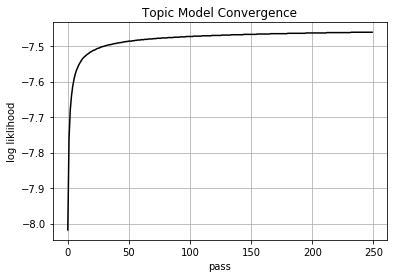

10 Topics:


[(0,
  '0.022*"Leben" + 0.016*"Welt" + 0.012*"sehen" + 0.011*"bleiben" + 0.009*"weiß" + 0.009*"Gott" + 0.008*"Herz" + 0.008*"lieben" + 0.008*"Auge" + 0.007*"Weg" + 0.007*"Mensch" + 0.007*"leben" + 0.007*"Traum" + 0.006*"tun" + 0.005*"Nacht" + 0.005*"seh" + 0.005*"sterben" + 0.005*"Licht" + 0.005*"Kopf" + 0.004*"glauben"'),
 (1,
  '0.032*"mal" + 0.013*"Mann" + 0.011*"sagen" + 0.011*"eine" + 0.009*"Frau" + 0.009*"mach" + 0.009*"einfach" + 0.008*"stehen" + 0.007*"denken" + 0.007*"Leute" + 0.007*"fragen" + 0.006*"sag" + 0.006*"nix" + 0.006*"weg" + 0.006*"Haus" + 0.006*"wär" + 0.006*"sehen" + 0.006*"nich" + 0.006*"ein" + 0.006*"drauf"'),
 (2,
  '0.090*"Baby" + 0.033*"komm" + 0.032*"weiß" + 0.030*"lieben" + 0.020*"Komm" + 0.020*"bitte" + 0.019*"sag" + 0.018*"Nacht" + 0.016*"zieh" + 0.015*"Sag" + 0.014*"lass" + 0.014*"wissen" + 0.012*"Babe" + 0.012*"Club" + 0.012*"Bitte" + 0.010*"fühlen" + 0.009*"Party" + 0.009*"vorbei" + 0.009*"tanzen" + 0.008*"geben"'),
 (3,
  '0.076*"Bitch" + 0.067*"yeah" 

In [23]:
filename = 'gensim_11.log'
create_logfile(filename)

num_topics = 10
chunksize = 1000
passes = 250
iterations = 10000
random_state = 973525


lda_model = LdaModel(
         corpus=corpus,
         id2word=id2word,
         num_topics=num_topics,
         passes=passes,
         iterations=iterations,
         chunksize=chunksize,
         alpha='auto',
         eta='auto',
         random_state=random_state
)

plot_passes(filename, passes)
print(f'{num_topics} Topics:')
lda_model.print_topics(num_words=20)

In [44]:
print(get_coherence_score(lda_model))

0.4534791872810759


In [98]:
num_topics = 5
chunksize = 1000
passes = 250
iterations = 1000
random_state = 8

lda_model = LdaModel(
         corpus=corpus,
         id2word=id2word,
         num_topics=num_topics,
         passes=passes,
         iterations=iterations,
         chunksize=chunksize,
         alpha='auto',
         eta='auto',
         random_state=random_state
)

print(f'{num_topics} Topics:')
print(get_coherence_score(lda_model))
lda_model.print_topics(num_words=20)

5 Topics:
0.4146591477974124


[(0,
  '0.011*"Bruder" + 0.011*"Geld" + 0.008*"mach" + 0.007*"Straße" + 0.006*"Benz" + 0.005*"Kopf" + 0.005*"Jungs" + 0.005*"Block" + 0.005*"Gang" + 0.005*"Bra" + 0.005*"eine" + 0.005*"Scheine" + 0.004*"geben" + 0.004*"Para" + 0.004*"weg" + 0.004*"Digga" + 0.004*"voll" + 0.004*"Fick" + 0.004*"paar" + 0.004*"Bratan"'),
 (1,
  '0.013*"Leben" + 0.009*"Welt" + 0.008*"sehen" + 0.008*"mal" + 0.007*"weiß" + 0.007*"bleiben" + 0.006*"lieben" + 0.005*"stehen" + 0.005*"Weg" + 0.005*"denken" + 0.005*"Gott" + 0.005*"Mann" + 0.005*"Herz" + 0.005*"Auge" + 0.005*"einfach" + 0.004*"Hand" + 0.004*"sagen" + 0.004*"weg" + 0.004*"Kopf" + 0.004*"leben"'),
 (2,
  '0.042*"Bitch" + 0.033*"yeah" + 0.020*"Money" + 0.019*"Bitches" + 0.018*"Yeah" + 0.013*"Geld" + 0.011*"ein" + 0.009*"eine" + 0.009*"Gucci" + 0.009*"Ice" + 0.009*"Cash" + 0.009*"Boss" + 0.008*"Boy" + 0.007*"Guck" + 0.006*"Louis" + 0.005*"like" + 0.005*"Hoes" + 0.005*"money" + 0.005*"Kette" + 0.005*"bang"'),
 (3,
  '0.010*"mal" + 0.010*"Rapper" + 0.00

In [7]:
def get_topic_from_song(model, title, artist=''):
    if artist == '':
        doc = docs[all_songs.index[all_songs['Title']==title][0]]
    else:
        song = genius.search_song(title, artist=artist)
        doc = preprocess_song(song.lyrics, artist)
        
    song_corpus = dictionary.doc2bow(doc)
    prob_distribution = model[song_corpus]
    topic = max(prob_distribution,key=itemgetter(1))[0]
    
    return topic

def get_topic_dist_from_song(model, title, artist=''):
    if artist == '':
        doc = docs[all_songs.index[all_songs['Title']==title][0]]
    else:
        song = genius.search_song(title, artist=artist)
        doc = preprocess_song(song.lyrics, artist)
        
    song_corpus = dictionary.doc2bow(doc)
    prob_distribution = model[song_corpus]
    
    return prob_distribution

In [8]:
def preprocess_song(lyrics, artist):
    docs_ = []
    doc = nlp(lyrics.replace(artist,''))
    lemmatized_doc = [token.lemma_ for token in doc if not token.is_stop and token.lemma_.isalpha() and len(token)>2]
    docs_.append(lemmatized_doc)

    en_stop_words = nlp_en.Defaults.stop_words
    docs_ = [[word for word in doc if not word.lower() in en_stop_words] for doc in docs_]

    bigram = Phrases(docs_, min_count=5)
    trigram = Phrases(bigram[docs_], min_count=5)

    for idx in range(len(docs_)):
        for token in trigram[bigram[docs_[idx]]]:
            if '_' in token:
                docs_[idx].append(token)
    
    return docs_[0]

In [131]:
Counter(pred)

Counter({'Kriminalität': 1296,
         'Leben & Lieben': 3080,
         'Rap': 2396,
         'Sex & Party': 351,
         'Status': 367})

In [136]:
num_topics = 6
chunksize = 1000
passes = 200
iterations = 1000
random_state = 8

lda_model_6 = LdaModel(
         corpus=corpus,
         id2word=id2word,
         num_topics=num_topics,
         passes=passes,
         iterations=iterations,
         chunksize=chunksize,
         alpha='auto',
         eta='auto',
         random_state=random_state
)

print(f'{num_topics} Topics:')
print(get_coherence_score(lda_model_6))
lda_model_6.print_topics(num_words=40)

6 Topics:
0.416375781914235


[(0,
  '0.013*"Geld" + 0.011*"Bruder" + 0.008*"mach" + 0.006*"Straße" + 0.006*"Benz" + 0.006*"eine" + 0.006*"Gang" + 0.005*"Scheine" + 0.005*"Jungs" + 0.005*"geben" + 0.005*"Block" + 0.005*"Bra" + 0.004*"Kopf" + 0.004*"voll" + 0.004*"weg" + 0.004*"Digga" + 0.004*"paar" + 0.004*"Para" + 0.004*"Fick" + 0.004*"Mach"'),
 (1,
  '0.021*"Leben" + 0.014*"Welt" + 0.010*"sehen" + 0.010*"bleiben" + 0.009*"Weg" + 0.008*"Gott" + 0.008*"Herz" + 0.008*"Auge" + 0.007*"Hand" + 0.007*"Kopf" + 0.007*"leben" + 0.006*"stehen" + 0.006*"Mensch" + 0.006*"Nacht" + 0.006*"Traum" + 0.005*"sterben" + 0.005*"liegen" + 0.004*"Licht" + 0.004*"Bruder" + 0.004*"mein"'),
 (2,
  '0.064*"Bitch" + 0.052*"yeah" + 0.029*"Yeah" + 0.029*"Money" + 0.026*"Bitches" + 0.015*"Boss" + 0.013*"ein" + 0.013*"Geld" + 0.012*"Gucci" + 0.011*"Boy" + 0.010*"zieh" + 0.010*"eine" + 0.010*"Cash" + 0.009*"Guck" + 0.008*"Hoes" + 0.008*"flieg" + 0.007*"Kid" + 0.007*"bang" + 0.007*"hol" + 0.007*"Bang"'),
 (3,
  '0.013*"Rapper" + 0.011*"Rap" + 0.0

In [159]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model_6, corpus, dictionary)
LDAvis_prepared

/home/luca/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.043238 -0.080539       1        1  24.137993
5      0.145600  0.014318       2        1  23.940693
1      0.212291 -0.100376       3        1  23.328171
0      0.038428 -0.034142       4        1  18.871731
4     -0.082095  0.347808       5        1   5.295849
2     -0.357463 -0.147069       6        1   4.425562, topic_info=     Category         Freq     Term        Total  loglift  logprob
term                                                              
142   Default  3719.000000     Baby  3719.000000  30.0000  30.0000
434   Default  3446.000000    Bitch  3446.000000  29.0000  29.0000
655   Default  2914.000000     yeah  2914.000000  28.0000  28.0000
615   Default  2593.000000     Yeah  2593.000000  27.0000  27.0000
161   Default  5547.000000    Leben  5547.000000  26.0000  26.0000
106   Default  4499.000000     komm  4499.000000  25.0000  25.0000
724   Default  1784.000000    Dicka  1784.000000  24.0000  24.0000
113   Default  7712.000000      mal  7712.000000  23.0000  23.0000
427   Default  4874.000000     weiß  4874.000000  22.0000  22.0000
229   Default  4539.000000     Geld  4539.000000  21.0000  21.0000
264   Default  3669.000000     Welt  3669.000000  20.0000  20.0000
603   Default  3275.000000   Rapper  3275.000000  19.0000  19.0000
1445  Default  1648.000000  Bitches  1648.000000  18.0000  18.0000
1776  Default  1322.000000    Money  1322.000000  17.0000  17.0000
371   Default  2784.000000      Rap  2784.000000  16.0000  16.0000
159   Default  2263.000000     Komm  2263.000000  15.0000  15.0000
1137  Default  3284.000000   lieben  3284.000000  14.0000  14.0000
696   Default  3043.000000    sagen  3043.000000  13.0000  13.0000
324   Default  3297.000000   Bruder  3297.000000  12.0000  12.0000
46    Default  2638.000000    Nacht  2638.000000  11.0000  11.0000
271   Default  3251.000000      ein  3251.000000  10.0000  10.0000
187   Default  2577.000000  einfach  2577.000000   9.0000   9.0000
340   Default  2029.000000     Gott  2029.000000   8.0000   8.0000
592   Default  1929.000000     Herz  1929.000000   7.0000   7.0000
150   Default  1066.000000     Boss  1066.000000   6.0000   6.0000
589   Default  1987.000000     Guck  1987.000000   5.0000   5.0000
88    Default  4624.000000     eine  4624.000000   4.0000   4.0000
203   Default  2820.000000      sag  2820.000000   3.0000   3.0000
613   Default  2514.000000      Weg  2514.000000   2.0000   2.0000
108   Default  2815.000000     lass  2815.000000   1.0000   1.0000
...       ...          ...      ...          ...      ...      ...
2570   Topic6    73.902847     Slut    74.728584   3.1067  -6.4396
434    Topic6  2958.317139    Bitch  3446.021484   2.9652  -2.7500
655    Topic6  2410.935059     yeah  2914.238281   2.9282  -2.9546
3173   Topic6   567.674133    Gucci   641.920044   2.9949  -4.4008
4631   Topic6   350.788574     Hoes   396.216064   2.9960  -4.8822
2848   Topic6   199.007538   ballen   216.697250   3.0326  -5.4490
1445   Topic6  1215.858765  Bitches  1648.520264   2.8133  -3.6391
3022   Topic6   337.922424     bang   417.965759   2.9052  -4.9195
2241   Topic6   500.867981      Boy   688.098022   2.8002  -4.5260
3295   Topic6   300.350647     Dick   383.261536   2.8740  -5.0374
150    Topic6   680.054688     Boss  1066.608398   2.6677  -4.2202
1531   Topic6   348.385345    flieg   472.240814   2.8136  -4.8890
615    Topic6  1352.086304     Yeah  2593.716553   2.4663  -3.5330
3021   Topic6   301.147430     Bang   404.700989   2.8222  -5.0348
3829   Topic6   246.073608      hey   328.337097   2.8294  -5.2367
4146   Topic6   257.557587      Gun   366.010803   2.7664  -5.1911
2127   Topic6   203.027328      BMW   286.769409   2.7724  -5.4290
4      Topic6   470.705109     Cash  1077.244629   2.2898  -4.5881
1037   Topic6   225.290558    Pussy   339.097473   2.7089  -5.3250
709    Topic6   484.153839     zieh  1202

In [9]:
def performance_test_known(model):
    pred_ = np.array([])
    wrong_labeled = []
    wrong_labeled_2 = []
    wrong_labeled_3 = []
    test_songs = ['Flow', 'Das ist für die Diebe', 'Zwiespalt', 'Sex mit dir', 'Action Muzik', 'Nike Pullover', 'Zirkus', 'Was Du Liebe nennst',
                  'Hip Hop muss am Leben bleiben', 'Party von uns', 'Zukunft', 'Zeit vergeht', 'Verflossene Liebe', 'Durchsuchungsbefehl',
                  'Welt In Flammen', 'Du', 'Versace', 'Tränen aus Kajal', 'Kripos jagen mich', 'Party 2', 'Das Geht Ab', 'Affen mit Waffen',
                  'Wenn sein Album kommt', 'Kopfgeld', 'Sie will es', 'Money', 'An Tagen wie diesen', 'Wenn ich kein Rapper wär', 'Pulsschlag',
                  'BITCHES', 'Kriminell', 'Mann im Spiegel', 'Nachtaktiv', 'Liebe', 'Gucci Pulli L', 'Hi Babe', 'Fremdgehen', 'Waffenarsenal',
                  'Style & das Geld', 'Alpha', 'Blei', 'Warum rappst Du?', 'Kein Liebeslied', 'MILLIONDOLLAR$MILE', 'Roli', 'Mermi Flow',
                  'OMG!', 'Hallo Welt!', 'Wenn du mich liebst', 'Ballen wie die Lakers', 'Hartreim Saga', 'Vollautomatik', 'Zu high', 
                  'Haus am See', 'Laura', 'Waffen', 'Dior 2001', 'Dieses Lied', 'Hash Hash', 'Von Party zu Party', 'Du Liebst Mich Nicht',
                  'Gott bietet mehr', 'Vater im Himmel', 'G€LD', 'Babygirl', 'Herz', 'Mainstream', 'Casanova', 'Isch liebe disch', 
                  'Deutscher Rapslum', 'Skyline', '1000 Bitches', 'Bam Bam', 'Lebe dein Leben', 'Wo sind sie jetzt', 'Pillen', 'Volles Magazin']
    test_label = np.array([3, 0, 2, 1, 3, 0, 3, 2, 3, 1, 3, 2, 2, 0, 3, 2, 4, 2, 0, 1, 1, 2, 3, 0, 1, 4, 2, 2, 3, 4, 0, 2, 1, 2, 4, 1, 2, 0, 4, 3, 0, 
                  3, 2, 4, 4, 3, 2, 2, 2, 4, 3, 0, 1, 2, 2, 0, 1, 2, 3, 1, 2, 2, 2, 4, 2, 2, 3, 1, 2, 3, 2, 4, 0, 2, 2, 1, 0])
    for i, song_title in enumerate(test_songs):
        pred_ = np.append(pred_, get_topic_from_song(model, song_title))
        if pred_[i] != test_label[i]:
            wrong_labeled.append((pred_[i], test_label[i]))
            wrong_labeled_2.append(pred_[i])
            wrong_labeled_3.append(test_label[i])
    correct_predictions = (pred_ == test_label).sum()
    print(f'Predicted {correct_predictions} of {len(test_label)} ({int(correct_predictions/len(test_label)*100)}%)')
    print(f'Incorrect labeling pairs: {Counter(wrong_labeled)}')
    print(f'Incorrect predictions: {Counter(wrong_labeled_2)}')
    print(f'Incorrectly predicted labels: {Counter(wrong_labeled_3)}')

In [311]:
performance_test_known(lda_model_6)

Predicted 45 of 77 (58%)
Incorrect labeling pairs: Counter({(0.0, 2): 5, (1.0, 5): 4, (5.0, 1): 4, (5.0, 4): 3, (5.0, 3): 3, (1.0, 4): 2, (3.0, 0): 2, (0.0, 3): 2, (3.0, 4): 1, (5.0, 2): 1, (1.0, 0): 1, (3.0, 2): 1, (0.0, 5): 1, (0.0, 4): 1, (4.0, 2): 1})
Incorrect predictions: Counter({5.0: 11, 0.0: 9, 1.0: 7, 3.0: 4, 4.0: 1})
Incorrectly predicted labels: Counter({2: 8, 4: 7, 5: 5, 3: 5, 1: 4, 0: 3})


In [56]:
random_state = 18
num_topics = 5
chunksize = 1000
passes = 250
iterations = 10000

lda_model = LdaModel(
         corpus=corpus,
         id2word=id2word,
         num_topics=num_topics,
         passes=passes,
         iterations=iterations,
         chunksize=chunksize,
         alpha='auto',
         eta='auto',
         random_state=random_state
)

print(f'{num_topics} Topics:')
print(get_coherence_score(lda_model))
lda_model.print_topics(num_words=30)

5 Topics:
0.4067005288169977


[(0,
  '0.020*"Bruder" + 0.015*"Geld" + 0.014*"Straße" + 0.011*"Mama" + 0.010*"Kopf" + 0.009*"Jungs" + 0.007*"raus" + 0.006*"Leben" + 0.006*"Block" + 0.006*"weg" + 0.006*"laufen" + 0.006*"Knast" + 0.005*"bleiben" + 0.005*"Stadt" + 0.005*"Weg" + 0.005*"rein" + 0.005*"reden" + 0.005*"leben" + 0.005*"Bulle" + 0.005*"schnellen" + 0.005*"Berlin" + 0.004*"Bratan" + 0.004*"Scheine" + 0.004*"Kugel" + 0.004*"paar" + 0.004*"voll" + 0.004*"Ghetto" + 0.004*"Feind" + 0.004*"geh" + 0.004*"Benz"'),
 (1,
  '0.041*"Baby" + 0.020*"komm" + 0.017*"weiß" + 0.014*"Komm" + 0.011*"yeah" + 0.011*"sag" + 0.010*"bitte" + 0.010*"Party" + 0.010*"zieh" + 0.009*"Nacht" + 0.008*"Club" + 0.007*"high" + 0.007*"geben" + 0.007*"voll" + 0.006*"tanzen" + 0.006*"wissen" + 0.005*"Babe" + 0.005*"Sex" + 0.005*"bleib" + 0.005*"Frau" + 0.005*"Yeah" + 0.005*"chill" + 0.005*"Nummer" + 0.005*"brauch" + 0.004*"hol" + 0.004*"vorbei" + 0.004*"Flasche" + 0.004*"Haus" + 0.004*"brauchen" + 0.004*"machen"'),
 (2,
  '0.013*"Leben" + 0.009*

In [11]:
file = datapath("lda_model")
#lda_model.save(file)
lda_model = LdaModel.load(file)

In [18]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
LDAvis_prepared

/home/luca/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.200142  0.007702       1        1  33.710415
3      0.032789 -0.043587       2        1  29.122103
0      0.150395 -0.140771       3        1  15.446572
4     -0.315043 -0.134226       4        1  11.761915
1     -0.068283  0.310881       5        1   9.958997, topic_info=     Category         Freq      Term        Total  loglift  logprob
term                                                               
141   Default  4252.000000      Baby  4252.000000  30.0000  30.0000
323   Default  3294.000000    Bruder  3294.000000  29.0000  29.0000
430   Default  4850.000000      weiß  4850.000000  28.0000  28.0000
107   Default  4553.000000      komm  4553.000000  27.0000  27.0000
744   Default  1988.000000     Dicka  1988.000000  26.0000  26.0000
66    Default  2590.000000    Straße  2590.000000  25.0000  25.0000
437   Default  3421.000000     Bitch  3421.000000  24.0000  24.0000
161   Default  5484.000000     Leben  5484.000000  23.0000  23.0000
230   Default  4463.000000      Geld  4463.000000  22.0000  22.0000
1182  Default  3297.000000    lieben  3297.000000  21.0000  21.0000
615   Default  3253.000000    Rapper  3253.000000  20.0000  20.0000
372   Default  2784.000000       Rap  2784.000000  19.0000  19.0000
159   Default  2311.000000      Komm  2311.000000  18.0000  18.0000
359   Default  1792.000000      Mama  1792.000000  17.0000  17.0000
671   Default  2868.000000      yeah  2868.000000  16.0000  16.0000
204   Default  2823.000000       sag  2823.000000  15.0000  15.0000
80    Default  1666.000000     bitte  1666.000000  14.0000  14.0000
1882  Default  1232.000000     Money  1232.000000  13.0000  13.0000
1516  Default  1624.000000   Bitches  1624.000000  12.0000  12.0000
23    Default  1996.000000     Jungs  1996.000000  11.0000  11.0000
728   Default  1215.000000      zieh  1215.000000  10.0000  10.0000
48    Default  2695.000000     Nacht  2695.000000   9.0000   9.0000
249   Default  1123.000000     Party  1123.000000   8.0000   8.0000
36    Default  3012.000000      Kopf  3012.000000   7.0000   7.0000
264   Default  3643.000000      Welt  3643.000000   6.0000   6.0000
95    Default  2266.000000      fick  2266.000000   5.0000   5.0000
1204  Default  1136.000000      Club  1136.000000   4.0000   4.0000
604   Default  1923.000000      Herz  1923.000000   3.0000   3.0000
627   Default  2490.000000       Weg  2490.000000   2.0000   2.0000
629   Default  2603.000000      Yeah  2603.000000   1.0000   1.0000
...       ...          ...       ...          ...      ...      ...
1221   Topic5   257.332123     Level   284.322540   2.2070  -6.0000
375    Topic5   548.707520       Sex   693.684570   2.0722  -5.2428
1929   Topic5   457.532257   Flasche   569.795044   2.0873  -5.4246
1607   Topic5   373.689484     flieg   461.164459   2.0964  -5.6270
159    Topic5  1409.351562      Komm  2311.809570   1.8118  -4.2995
80     Topic5  1055.630005     bitte  1666.444092   1.8501  -4.5885
107    Topic5  2087.329102      komm  4553.348633   1.5267  -3.9068
1667   Topic5   422.312439   trinken   571.218079   2.0047  -5.5047
648    Topic5   285.878296      like   346.360382   2.1148  -5.8948
764    Topic5   384.499176      Glas   525.627930   1.9940  -5.5985
430    Topic5  1770.826050      weiß  4850.796387   1.2990  -4.0712
204    Topic5  1099.656494       sag  2823.965332   1.3635  -4.5477
671    Topic5  1104.448486      yeah  2868.452393   1.3523  -4.5433
773    Topic5   374.552917     Joint   521.880798   1.9750  -5.6247
48     Topic5   918.801453     Nacht  2695.190674   1.2305  -4.7273
69     Topic5   369.970917     Tisch   520.647461   1.9650  -5.6370
1150   Topic5   487.137054    Nummer   918.607361   1.6724  -5.3619
305    Topic5   675.631653      voll  2627.239746   0.9487  -5.0348
277    Topic5   691.141296     geben  3109.822998   0.8027  -5.0121
82     Topic5   533.767639     bleib  1591.

In [16]:
pred = []
for index, song in all_songs.iterrows():
    pred.append(get_topic_from_song(lda_model, song['Title']))
all_songs['Label'] = pred

In [19]:
topic_dists = {
'topic_0': [],
'topic_1': [],
'topic_2': [],
'topic_3': [],
'topic_4': []}

for index, song in all_songs.iterrows():
    dist_ = get_topic_dist_from_song(lda_model, song['Title'])
    
    for i in range(0,5):
        try:
            topic, prob = dist_[i]
            if i != topic:
                dist_.insert(i, (i, 0.0))
        except:
            dist_.append((i, 0.0))

    for (topic, prob) in dist_:
        topic_dists[f'topic_{topic}'].append(prob)

In [20]:
all_songs['Street'] = topic_dists['topic_0']
all_songs['Sex & Party'] = topic_dists['topic_1']
all_songs['Love & Life'] = topic_dists['topic_2']
all_songs['Competition'] = topic_dists['topic_3']
all_songs['Lifestyle'] = topic_dists['topic_4']

In [21]:
all_songs

,Title,Artist,Release,Lyrics,Label,Street,Sex & Party,Love & Life,Competition,Lifestyle
0,100er Batzen,187 Strassenbande,2017,"Ich brauch' Hunderterbatzen, Klunker um'n Nac...",0,0.513944,0.040560,0.123368,0.199157,0.122971
1,100k,187 Strassenbande,2017,"Wir sind gekomm'n, um zu bleiben und keiner w...",1,0.343889,0.361652,0.210455,0.082248,0.000000
2,10 Dinger,187 Strassenbande,2017,"Ich schwör' dir, wenn ich mal Kohle mache, da...",0,0.306380,0.186618,0.131671,0.203382,0.171950
3,10 Jahre,187 Strassenbande,2016,"Daimler frisiert, zweimal foliert Gazi hat an...",0,0.407386,0.107336,0.224292,0.220019,0.040967
4,24/7,187 Strassenbande,2017,"Seite mit Messer, gleic h geht's mir besser T...",0,0.422052,0.024046,0.146919,0.242066,0.164917
5,30er Zone,187 Strassenbande,2017,"Dreiunddreißig Grad, lass die Chromfelge au...",0,0.451660,0.237456,0.048543,0.128574,0.133767
6,95 - 09,187 Strassenbande,2009,"""... du bist ein Rapper!"" ’96: Snoop Doggy ...",3,0.084654,0.193087,0.157173,0.501127,0.063960
7,Alles ist entspannt,187 Strassenbande,2011,Bring mein Namen an die Wand! Ich zieh es ...,2,0.291616,0.160336,0.331071,0.165057,0.051920
8,Allstars 2017,187 Strassenbande,2017,"Sa zu der 4, zu oft totgeschwiegen Bezahl' di...",0,0.334133,0.066148,0.163541,0.288524,0.147654
9,Auf der Jagd nach Papier,187 Strassenbande,2011,Jetzt werde ich euch Strichern mal was zeigen...,0,0.459849,0.034814,0.373282,0.054888,0.077168


In [65]:
performance_test_known(lda_model)

Predicted 57 of 77 (74%)
Incorrect labeling pairs: Counter({(2.0, 1): 4, (2.0, 3): 3, (3.0, 0): 3, (4.0, 3): 2, (4.0, 0): 2, (2.0, 4): 1, (2.0, 0): 1, (3.0, 4): 1, (0.0, 4): 1, (4.0, 1): 1, (1.0, 4): 1})
Incorrect predictions: Counter({2.0: 9, 4.0: 5, 3.0: 4, 0.0: 1, 1.0: 1})
Incorrectly predicted labels: Counter({0: 6, 1: 5, 3: 5, 4: 4})


In [22]:
topics_by_release = all_songs.groupby(['Release']).mean()
topics_by_release = topics_by_release.drop(['0001','1980', '2021'])
topics_by_release = topics_by_release.drop(columns=['Label'])

In [36]:
%matplotlib inline
font = {'family': 'DejaVu Sans',
        'size': 16}
plt.rc('font', **font)
plt.rcParams["figure.figsize"] = [14, 7]

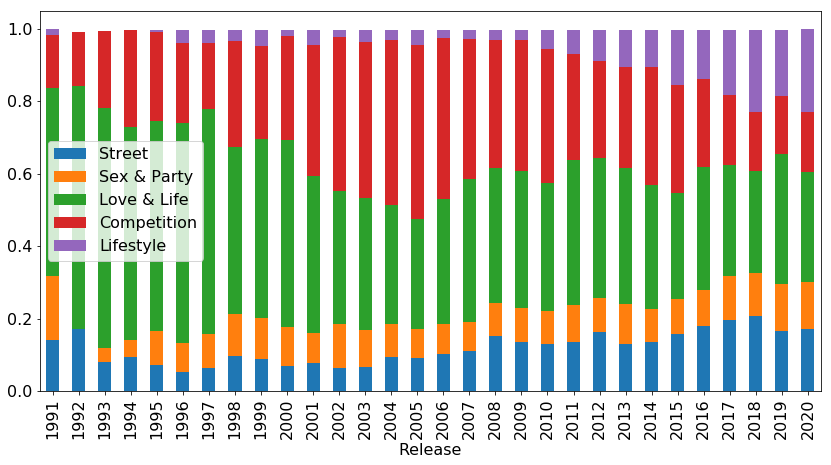

In [37]:
topics_by_release.plot.bar(stacked=True)

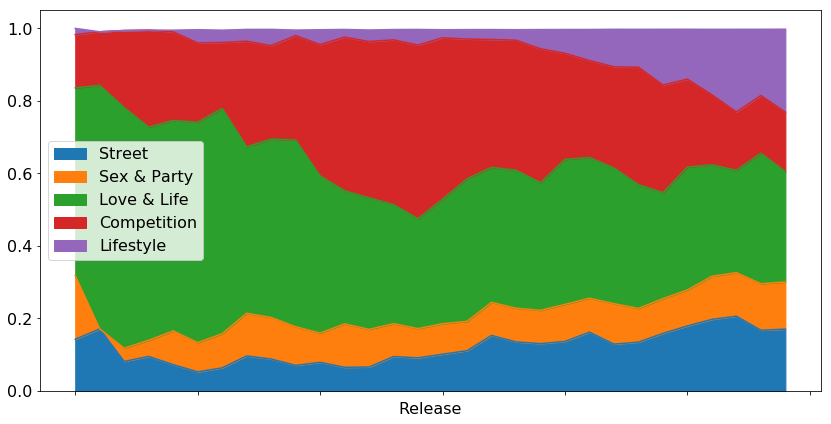

In [38]:
topics_by_release.plot.area(sharex=False)

In [25]:
topics_by_artist = all_songs.groupby(['Artist']).mean()
topics_by_artist = topics_by_artist.drop(columns=['Label'])

In [280]:
df_ = pd.DataFrame(transformed_topics, index=topics_by_artist.index)
dist_df = pd.DataFrame(distance_matrix(df_.values, df_.values), index = df_.index, columns = df_.index)
artist_med = dist_df.median().median()

def assert_artist_relation(artist_1, artist_2, positive=True):
    dist = dist_df[artist_1][artist_2]
    print((dist < artist_med) == positive)
    print(f'The median distance between all artists is {artist_med}')
    print(f'The distance between {artist_1} and {artist_2} is {dist}')

In [283]:
assert_artist_relation('Azad', 'Bushido')
assert_artist_relation('Capital Bra', 'Samra')
assert_artist_relation('Bonez MC', 'RAF Camora')
assert_artist_relation('Bonez MC', 'Gzuz')
assert_artist_relation('187 Strassenbande', 'Gzuz')
assert_artist_relation('Apache 207', 'Bausa')
assert_artist_relation('Samy Deluxe', 'Kool Savas')
assert_artist_relation('K.I.Z', 'Trailerpark')
assert_artist_relation('Trailerpark', 'Alligatoah')
assert_artist_relation('Shindy', 'Fler')
assert_artist_relation('Eno', 'Fero47')
assert_artist_relation('Jan Delay', 'Peter Fox')

True
The median distance between all artists is 0.2501542055268841
The distance between Azad and Bushido is 0.06855219915699752
True
The median distance between all artists is 0.2501542055268841
The distance between Capital Bra and Samra is 0.17098828730411192
True
The median distance between all artists is 0.2501542055268841
The distance between Bonez MC and RAF Camora is 0.1952578114552474
True
The median distance between all artists is 0.2501542055268841
The distance between Bonez MC and Gzuz is 0.0825440805149859
True
The median distance between all artists is 0.2501542055268841
The distance between 187 Strassenbande and Gzuz is 0.09501600069988093
True
The median distance between all artists is 0.2501542055268841
The distance between Apache 207 and Bausa is 0.07164344216189913
True
The median distance between all artists is 0.2501542055268841
The distance between Samy Deluxe and Kool Savas is 0.1861426230703238
True
The median distance between all artists is 0.2501542055268841
The

In [ ]:
%matplotlib inline
font = {'family': 'DejaVu Sans',
        'size': 12}
plt.rc('font', **font)
plt.rcParams["figure.figsize"] = [20, 10]

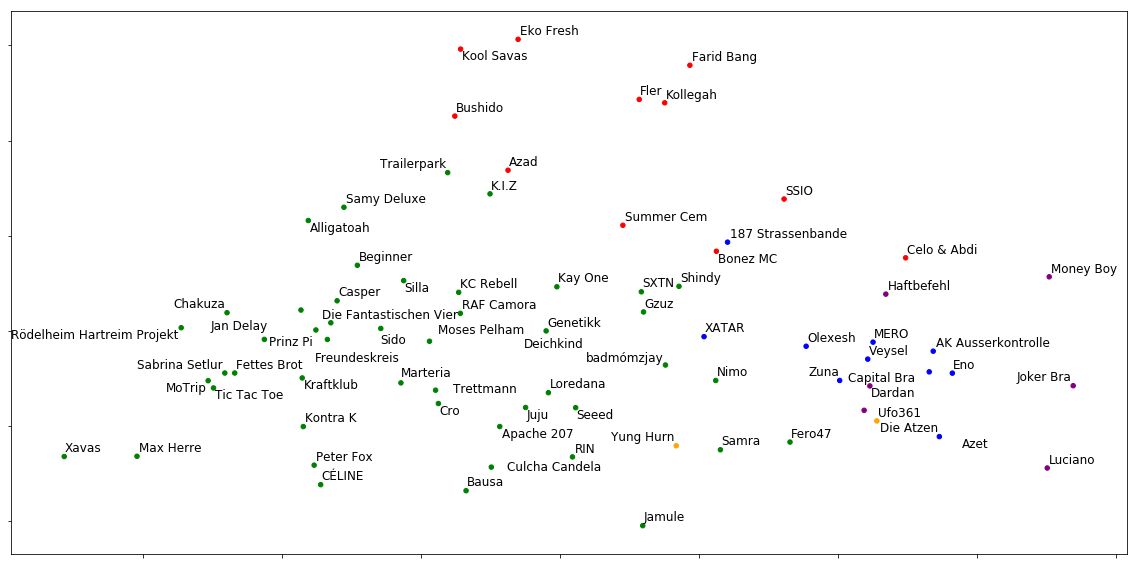

In [368]:
pca = sklearn.decomposition.PCA(n_components=2)
transformed_topics = pd.DataFrame(pca.fit_transform(topics_by_artist), index=topics_by_artist.index)

texts_ = []
main_colors = [(0,0,1), (1.0, 0.6470588235294118, 0.0), (0.0, 0.5019607843137255, 0.0), (1,0,0), (0.5019607843137255, 0.0, 0.5019607843137255)]
colors = []

for idx, row in topics_by_artist.iterrows():
    colors.append(main_colors[np.argmax(row.tolist())])

ax = transformed_topics.plot.scatter(x=0, y=1, c=colors)
for i, txt in enumerate(topics_by_artist.index):
    texts_.append(ax.annotate(txt, (transformed_topics.iloc[:,0].iat[i],transformed_topics.iloc[:,1].iat[i])))
    
adjust_text(texts_)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.show()

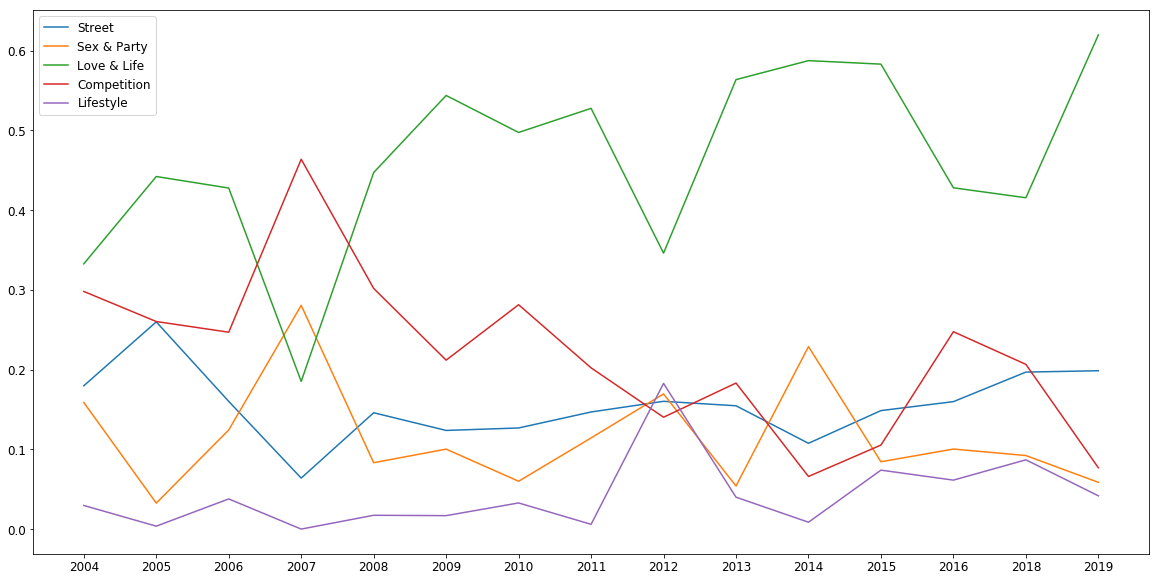

In [397]:
sido_ = all_songs[all_songs['Artist']=='Sido']
sido_ = sido_.groupby(['Release']).mean()
# only 4 songs in these 3 years, not meaningful
sido_ = sido_.drop(['1980', '2002', '2003'])
sido_ = sido_.drop(columns=['Label', 'Popularity'])
plt.plot(sido_)
plt.legend(['Street', 'Sex & Party', 'Love & Life', 'Competition', 'Lifestyle'])
plt.xticks(sido_.index)
plt.show()

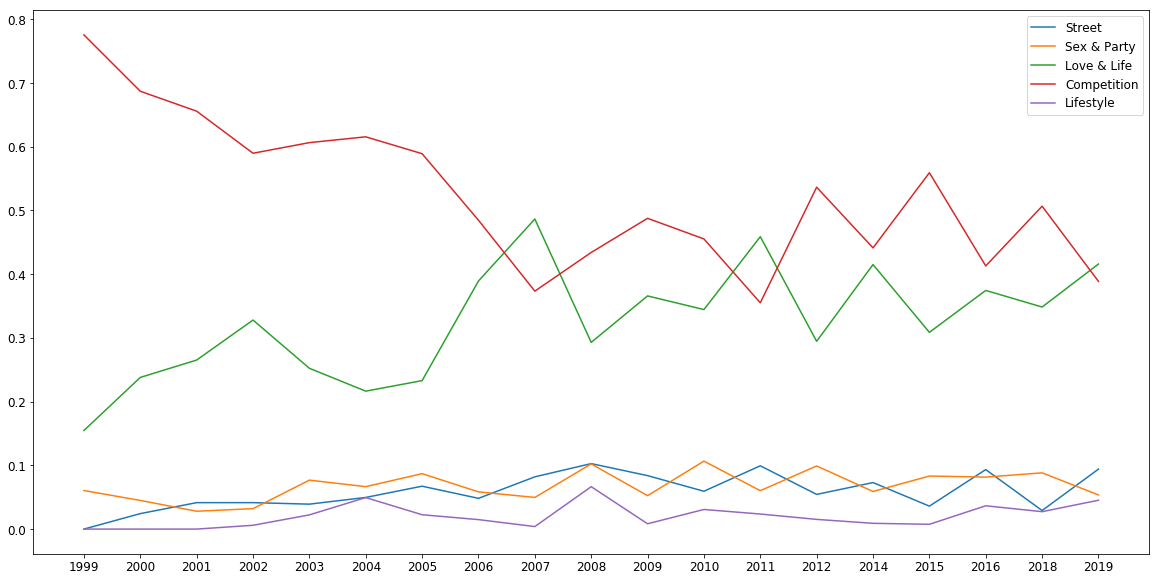

In [407]:
savas_ = all_songs[all_songs['Artist']=='Kool Savas']
savas_ = savas_.groupby(['Release']).mean()
# only 1 songs in 2020
savas_ = savas_.drop(['2020'])
savas_ = savas_.drop(columns=['Label', 'Popularity'])
plt.plot(savas_)
plt.legend(['Street', 'Sex & Party', 'Love & Life', 'Competition', 'Lifestyle'])
plt.xticks(savas_.index)
plt.show()

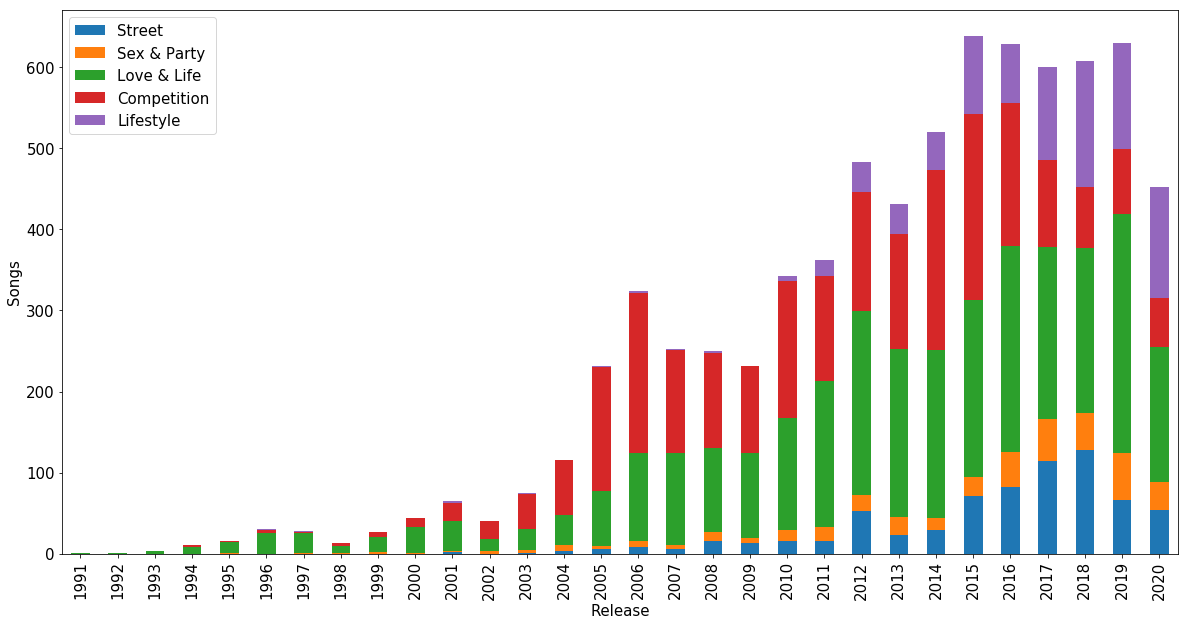

In [142]:
labels_by_release = all_songs.drop(columns=['Street', 'Sex & Party', 'Love & Life', 'Competition', 'Lifestyle', 'Artist', 'Title', 'Lyrics'])

labels_by_release = labels_by_release.groupby(['Release', 'Label'])['Label'].count()
labels_by_release = labels_by_release.drop(['0001', '1980', '2021'])
ax = pd.DataFrame(labels_by_release).unstack(level=1).plot.bar(stacked=True)
ax.set_ylabel('Songs')
ax.legend(['Street', 'Sex & Party', 'Love & Life', 'Competition', 'Lifestyle'])

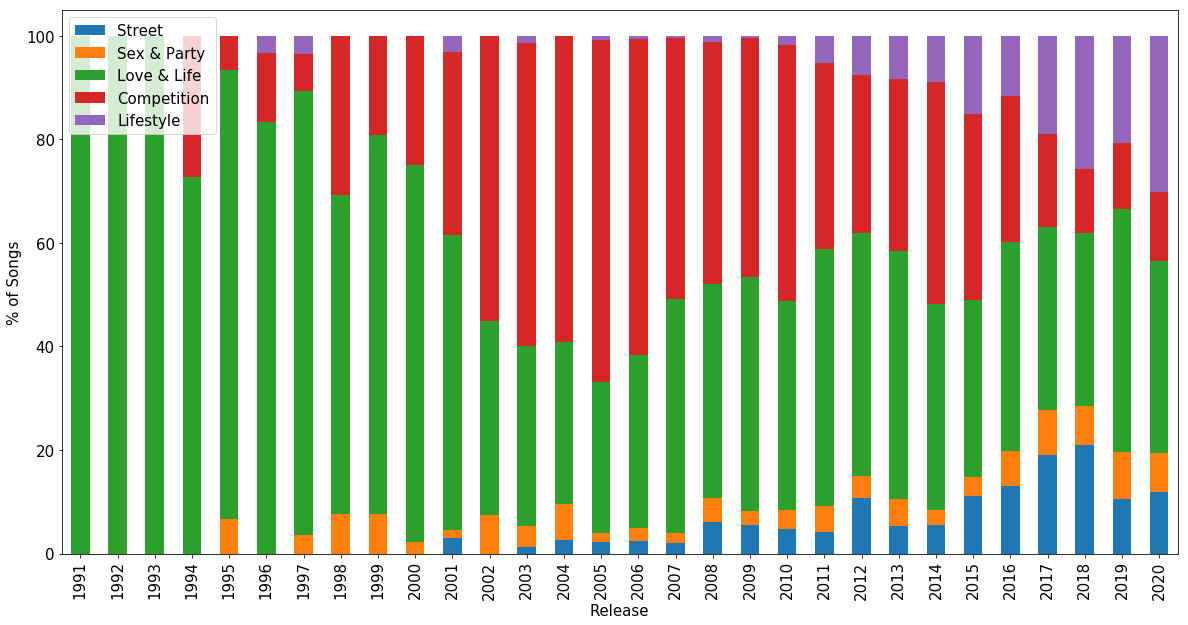

In [167]:
norm_lbr = pd.DataFrame(labels_by_release).unstack(level=1).fillna(0)

for idx, row in norm_lbr.iterrows():
    row = row.copy()
    norm_lbr.loc[idx] = row/sum(row)*100
    
ax = norm_lbr.plot.bar(stacked=True)
ax.set_ylabel('% of Songs')
ax.legend(['Street', 'Sex & Party', 'Love & Life', 'Competition', 'Lifestyle'])

In [202]:
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id="9e57eb45ef384c71944be64132ebb78d",
                                                           client_secret="d56cc78dbab64789a105cbf8769574bb"))

popularities = []

for idx, song in all_songs.iterrows():
    artist = song['Artist']
    title = song['Title']
    query = f'{artist} {title}'
    results = sp.search(q=query, limit=1, market='DE')
    if results['tracks']['items'] != []:
        popularity = results['tracks']['items'][0]['popularity']
    else:
        # fallback to just searching the title
        results = sp.search(q=title, limit=1, market='DE')
        if results['tracks']['items'] != []:
            popularity = results['tracks']['items'][0]['popularity']
        else:
            # fallback to setting popularity to 0
            popularity = 0
    print(f'{query}, popularity: {popularity}')
    popularities.append(popularity)

187 Strassenbande 100er Batzen, popularity: 54
187 Strassenbande 100k, popularity: 59
187 Strassenbande 10 Dinger, popularity: 46
187 Strassenbande 10 Jahre, popularity: 60
187 Strassenbande 24/7, popularity: 48
187 Strassenbande 30er Zone, popularity: 49
187 Strassenbande 95 - 09, popularity: 34
187 Strassenbande Alles ist entspannt, popularity: 32
187 Strassenbande Allstars 2017, popularity: 26
187 Strassenbande Auf der Jagd nach Papier, popularity: 35
187 Strassenbande Bademantel, popularity: 41
187 Strassenbande Ballermann, popularity: 49
187 Strassenbande Bis die Lage eskaliert, popularity: 37
187 Strassenbande Bis jetzt alles cool, popularity: 30
187 Strassenbande Bockt nicht!, popularity: 27
187 Strassenbande Compton, popularity: 52
187 Strassenbande Das Bonez, popularity: 46
187 Strassenbande Das Gangsta, popularity: 35
187 Strassenbande Das Volk, das sind wir!, popularity: 34
187 Strassenbande Draufgänger, popularity: 47
187 Strassenbande Dreh’s wie ’ne 8, popularity: 40
187 S

Alligatoah Der einzig(st)e Terrorist im Dorf, popularity: 27
Alligatoah Der Zensor, popularity: 44
Alligatoah Der Zensor 2, popularity: 0
Alligatoah Der Zensor ist tot, popularity: 0
Alligatoah Die Gangster und der Terrorist, popularity: 0
Alligatoah Die grüne Regenrinne I, popularity: 40
Alligatoah Die grüne Regenrinne II, popularity: 39
Alligatoah Die grüne Regenrinne III, popularity: 38
Alligatoah Die Kunst des Bitens, popularity: 31
Alligatoah Die Kunst des Bitens Reloaded, popularity: 0
Alligatoah Doktor spielen, popularity: 47
Alligatoah Drei Schwänze, popularity: 25
Alligatoah Du bist schön, popularity: 63
Alligatoah Du hast Recht, popularity: 30
Alligatoah Dunkel wars, popularity: 41
Alligatoah Du SchmuTzz, popularity: 33
Alligatoah Einen drauf, popularity: 39
Alligatoah Eine Welt, popularity: 26
Alligatoah Ein Problem mit Alkohol, popularity: 60
Alligatoah Erntedank, popularity: 46
Alligatoah Es gibt einen Ort, popularity: 28
Alligatoah Es ist noch Suppe da, popularity: 37
All

Azad Bang, popularity: 55
Azad Beat Kune-Do, popularity: 13
Azad Blackout, popularity: 57
Azad Blind, popularity: 22
Azad Blockfeuer, popularity: 12
Azad Blocktränen, popularity: 18
Azad Bozz, popularity: 20
Azad Bozz Effekt, popularity: 20
Azad Braveheart, popularity: 28
Azad Brenn, popularity: 24
Azad BTTR/BITD, popularity: 28
Azad Bündel Für Bündel, popularity: 22
Azad C’est la vie, popularity: 35
Azad Conor McGregor, popularity: 47
Azad Das is’ A, popularity: 1
Azad Das Verhör, popularity: 12
Azad Der Bozz, popularity: 19
Azad Der Bozz & der Baus, popularity: 13
Azad Detonation, popularity: 23
Azad Diego, popularity: 34
Azad Dieser Weg, popularity: 38
Azad Direkt aus dem Viertel, popularity: 10
Azad Drama, popularity: 21
Azad Dreh ab, popularity: 34
Azad Drive by Sound, popularity: 22
Azad DSSAM, popularity: 23
Azad Du fehlst mir, popularity: 31
Azad Durchgriff, popularity: 20
Azad DYNAMIT, popularity: 42
Azad Ehre & Stärke, popularity: 18
Azad Eigener Bozz, popularity: 34
Azad Ein

Beginner Frehnwarts Nutzsignal, popularity: 0
Beginner Füchse, popularity: 54
Beginner Geh’ Bitte, popularity: 33
Beginner Get funky Bulle, popularity: 0
Beginner Hammerhart, popularity: 49
Beginner Hip Hop muss am Leben bleiben, popularity: 0
Beginner Kater, popularity: 37
Beginner K.E.I.N.E, popularity: 21
Beginner Liebeslied, popularity: 43
Beginner Macha Macha, popularity: 33
Beginner Meine Posse, popularity: 45
Beginner Multichill, popularity: 50
Beginner Nach Hause, popularity: 31
Beginner Natural Born Chillas, popularity: 22
Beginner Pissen from outta Space, popularity: 0
Beginner Planet 2000, popularity: 52
Beginner Rambo No. 5, popularity: 33
Beginner Rap & fette Bässe, popularity: 34
Beginner Rapmiles, popularity: 25
Beginner Rock On, popularity: 40
Beginner Schelle, popularity: 38
Beginner So schön, popularity: 40
Beginner Spacemadness, popularity: 4
Beginner Spam, popularity: 32
Beginner Thomas Anders, popularity: 35
Bonez MC 16er für Gangstaz.com, popularity: 0
Bonez MC 18

Bushido Gemein wie 10, popularity: 28
Bushido Gemein wie 100, popularity: 28
Bushido Geschichten, die das Leben erzählt, popularity: 29
Bushido Geschlossene Gesellschaft, popularity: 40
Bushido Gestern war gestern, popularity: 54
Bushido Gesucht und Gefunden, popularity: 31
Bushido Gibt es dich?, popularity: 42
Bushido Goldrapper, popularity: 28
Bushido Graues Haar, popularity: 40
Bushido Grenzenlos, popularity: 38
Bushido Ground Zero, popularity: 36
Bushido Guck dich um, popularity: 39
Bushido Hades, popularity: 53
Bushido Haifisch, popularity: 64
Bushido Hai Life, popularity: 28
Bushido Harter Brocken, popularity: 23
Bushido Hass, popularity: 32
Bushido Hassliebe, popularity: 29
Bushido Hast du was bist du was, popularity: 48
Bushido Heavy Metal, popularity: 26
Bushido Heile Welt, popularity: 33
Bushido Hinter dem Horizont, popularity: 31
Bushido Hochmut, popularity: 36
Bushido Hoffnung stirbt zuletzt, popularity: 37
Bushido Human Centipede, popularity: 53
Bushido Hunde, die bellen, 

Capital Bra Boss Rap, popularity: 54
Capital Bra Bra, popularity: 54
Capital Bra Bra hinter dir, popularity: 35
Capital Bra Bra macht die AK, popularity: 41
Capital Bra Bra macht die Uzi, popularity: 41
Capital Bra Bratan ist OK, popularity: 31
Capital Bra Braun, gelb, lila, popularity: 36
Capital Bra Bruda, popularity: 37
Capital Bra Bye Bye, popularity: 56
Capital Bra Cabriolet, popularity: 48
Capital Bra Capital Bra je m’appelle, popularity: 54
Capital Bra Cherry Lady, popularity: 63
Capital Bra Click Click, popularity: 51
Capital Bra Columbia, popularity: 48
Capital Bra Danke dir Bruder, popularity: 0
Capital Bra Darby, popularity: 46
Capital Bra Das Leben ist so, popularity: 45
Capital Bra Dealer, popularity: 39
Capital Bra Der Bratan bleibt der Gleiche, popularity: 61
Capital Bra Der Teufel trägt Gucci, popularity: 36
Capital Bra Deutlich genug, popularity: 0
Capital Bra Die Echten, popularity: 51
Capital Bra ​dir zu liebe, popularity: 36
Capital Bra Du siehst, popularity: 42
Cap

Casper XOXO, popularity: 49
Casper Zauber Pur, popularity: 22
Celo & Abdi 20 Zoll MAE, popularity: 62
Celo & Abdi A2zlack, popularity: 46
Celo & Abdi A.C.A.B., popularity: 38
Celo & Abdi Akupunktur, popularity: 23
Celo & Abdi Amo aller Amos, popularity: 42
Celo & Abdi Aroma der Großstadt, popularity: 28
Celo & Abdi Aslan Sound, popularity: 29
Celo & Abdi Auf Achse, popularity: 32
Celo & Abdi Auf der Jagd, popularity: 53
Celo & Abdi Auf Jetzt!, popularity: 30
Celo & Abdi Autre Jour, popularity: 18
Celo & Abdi Besuchstag, popularity: 58
Celo & Abdi Bis sich alles dreht, popularity: 37
Celo & Abdi Blendoui, popularity: 26
Celo & Abdi Bonchance, popularity: 36
Celo & Abdi Chabula, popularity: 27
Celo & Abdi Chivato, popularity: 27
Celo & Abdi Das ist erst der Anfang, popularity: 23
Celo & Abdi Diaspora, popularity: 33
Celo & Abdi Digitalwaagendisplays, popularity: 50
Celo & Abdi Directors Cut, popularity: 62
Celo & Abdi Duo Numero Uno, popularity: 30
Celo & Abdi Durchsuchungsbefehl, popula

Chakuza Last Two, popularity: 18
Chakuza Leaving Las Vegas, popularity: 26
Chakuza Legenden, popularity: 58
Chakuza Licht aus, popularity: 30
Chakuza Licht und Schatten, popularity: 21
Chakuza Manchild, popularity: 49
Chakuza Mein Kopf Mein Herz, popularity: 31
Chakuza Mein Name, popularity: 23
Chakuza Mond, popularity: 20
Chakuza Monster, popularity: 23
Chakuza M.O.T.U., popularity: 32
Chakuza Nanana, popularity: 13
Chakuza Neben mir, popularity: 16
Chakuza Nicht mehr, popularity: 28
Chakuza Nicht Mehr Hier, popularity: 17
Chakuza Nimm mich mit, popularity: 23
Chakuza NOAH, popularity: 22
Chakuza No Homo, popularity: 40
Chakuza Notlandung Auf Berlin, popularity: 26
Chakuza Notre Dame, popularity: 31
Chakuza Nur wenn ich schlafe, popularity: 33
Chakuza Off, popularity: 42
Chakuza Ohne Worte, popularity: 36
Chakuza Outro 2.0, popularity: 28
Chakuza Over the Top, popularity: 29
Chakuza Over the Top 2.0, popularity: 29
Chakuza Polarlicht, popularity: 22
Chakuza Prag, popularity: 19
Chakuz

CÉLINE Was machst du da?, popularity: 55
CÉLINE Wenn ich will, popularity: 60
CÉLINE Zu Besuch, popularity: 55
Dardan 1.000.000 $, popularity: 35
Dardan 10 Euro Samsung, popularity: 65
Dardan 10 Euro Samsung Remix, popularity: 0
Dardan 6AM........., popularity: 63
Dardan ​aAliYAh, popularity: 38
Dardan Airmax gegen Kopf, popularity: 52
Dardan Albanian Inhale, popularity: 27
Dardan Albo Trap, popularity: 39
Dardan Albo Trap Part.2, popularity: 0
Dardan AMIGA, popularity: 45
Dardan Amigo, popularity: 30
Dardan ​a miLLy, popularity: 51
Dardan Atención, popularity: 25
Dardan Atme durch, popularity: 26
Dardan AUGEN, popularity: 40
Dardan BELLA CIAO, popularity: 39
Dardan Bla Bla Bla, popularity: 43
Dardan Boulevard, popularity: 26
Dardan Charlie Raffaello, popularity: 29
Dardan Cocaine Cowboys, popularity: 34
Dardan ​cOcO MAmA, popularity: 59
Dardan Dardy Luther King, popularity: 35
Dardan DARDYNEXTDOOR, popularity: 26
Dardan D A YYY T O N A, popularity: 58
Dardan Details, popularity: 53
Da

Eko Fresh Aber, popularity: 39
Eko Fresh AfD = Albtraum für Deutschland!, popularity: 0
Eko Fresh Alles im Lot, popularity: 12
Eko Fresh Alles im Lot 2, popularity: 5
Eko Fresh Alles oder nichts, popularity: 4
Eko Fresh All I Need, popularity: 60
Eko Fresh All or Nothing, popularity: 12
Eko Fresh Almanis, popularity: 19
Eko Fresh Alta, popularity: 15
Eko Fresh Alte Zeit, popularity: 15
Eko Fresh Al vs. Eko Fresh, popularity: 0
Eko Fresh An alle Ladies dieser Welt, popularity: 0
Eko Fresh Anders, popularity: 51
Eko Fresh Angemessen, popularity: 0
Eko Fresh Angie, popularity: 4
Eko Fresh Antigaranti 4 Life, popularity: 8
Eko Fresh Antigaranti 4 Life 2020, popularity: 8
Eko Fresh Anti Garranti, popularity: 14
Eko Fresh Arbeitssieg, popularity: 7
Eko Fresh Arschloch, popularity: 11
Eko Fresh Aufstand, popularity: 28
Eko Fresh Augenbrauen, popularity: 11
Eko Fresh Aus dem Weg da, popularity: 3
Eko Fresh Bang Bang, popularity: 26
Eko Fresh Bars in euren Arsch, popularity: 26
Eko Fresh Bars ü

Eko Fresh Klassentreffen, popularity: 15
Eko Fresh Köln Kalk Ehrenmord, popularity: 39
Eko Fresh Komm her, popularity: 16
Eko Fresh Komm in meine Hood rein, popularity: 20
Eko Fresh Königin der Nacht, popularity: 23
Eko Fresh König von Deutschland, popularity: 23
Eko Fresh König von Deutschland - Part II, popularity: 0
Eko Fresh König von Deutschland RMX, popularity: 13
Eko Fresh Landsleute, popularity: 18
Eko Fresh Landsleute 2, popularity: 15
Eko Fresh Lan lass ma ya, popularity: 1
Eko Fresh Lappen, popularity: 5
Eko Fresh Läuft/Reicht, popularity: 15
Eko Fresh Leichte Beute, popularity: 16
Eko Fresh Leko Mio, popularity: 28
Eko Fresh Liebe Nachbarin, popularity: 8
Eko Fresh Life Goes On, popularity: 14
Eko Fresh Live zu gut, popularity: 38
Eko Fresh Mach dich grade Fotze, popularity: 0
Eko Fresh Mach kein Politik, popularity: 8
Eko Fresh Mach ma keine Filme, popularity: 18
Eko Fresh Mach’n Taui, popularity: 0
Eko Fresh Manche sind so, popularity: 10
Eko Fresh Master P, popularity: 1

Farid Bang 110, popularity: 23
Farid Bang 24 Kugeln, popularity: 18
Farid Bang 3 Mal im Leben, popularity: 6
Farid Bang 3XNO, popularity: 66
Farid Bang 40 Kugeln, popularity: 0
Farid Bang Alemania, popularity: 33
Farid Bang Allez Allez, popularity: 42
Farid Bang An die Wand, popularity: 26
Farid Bang Arm aus’m Fenster, popularity: 51
Farid Bang Asozialer Marokkaner, popularity: 43
Farid Bang Asphalt Massaka, popularity: 33
Farid Bang Asphalt Massaka 3, popularity: 33
Farid Bang Bang Bang, popularity: 31
Farid Bang Banger Imperium, popularity: 29
Farid Bang Banger leben kürzer, popularity: 38
Farid Bang Banger Musik, popularity: 36
Farid Bang Banger Musiker, popularity: 26
Farid Bang Bentley, popularity: 39
Farid Bang Benz Mansory, popularity: 35
Farid Bang Bitte Spitte 5000, popularity: 41
Farid Bang Bitte Spitte Toi Lab, popularity: 41
Farid Bang Bladi Musik, popularity: 22
Farid Bang Blut auf dem Asphalt, popularity: 72
Farid Bang Casanova, popularity: 50
Farid Bang CHING CHING CHING

Fettes Brot Hier drinne, popularity: 16
Fettes Brot Hubschraubermütze, popularity: 0
Fettes Brot Ich bin müde, popularity: 35
Fettes Brot Ich hasse das, popularity: 16
Fettes Brot Ich liebe mich, popularity: 33
Fettes Brot ​iKEA, popularity: 31
Fettes Brot In ist, popularity: 19
Fettes Brot Jugend forscht, popularity: 22
Fettes Brot Kannste Kommen, popularity: 32
Fettes Brot Kinder im Hof, popularity: 0
Fettes Brot Klapse, popularity: 26
Fettes Brot Kleiner Nager, popularity: 0
Fettes Brot Kleines Kind, popularity: 17
Fettes Brot Könnten Sie mich kurz küssen?, popularity: 15
Fettes Brot Kontrolle, popularity: 22
Fettes Brot Krankenhausreif, popularity: 14
Fettes Brot Kuba, popularity: 25
Fettes Brot Lauterbach, popularity: 28
Fettes Brot Lichterloh, popularity: 16
Fettes Brot Lua spricht, popularity: 0
Fettes Brot Mal sehen, popularity: 26
Fettes Brot Männer, popularity: 15
Fettes Brot Meh’ Bier, popularity: 20
Fettes Brot Mehr Gefühl, popularity: 15
Fettes Brot Mikrokosmonaut, popular

Fler Ich Bin Deutscha, popularity: 17
Fler Ich bleib wie ich bin, popularity: 29
Fler Ich fick dich, popularity: 16
Fler Ich häng auf den Strassen ab, popularity: 23
Fler Ich Kann Dich Sehen, popularity: 15
Fler Ich scheine, popularity: 11
Fler Ich schwöre, popularity: 17
Fler Ich sing nicht mehr für dich, popularity: 32
Fler Ich spiel, Um Zu Gewinnen, popularity: 17
Fler Ich ticke am Block, popularity: 8
Fler Ich und keine Maske Flavour, popularity: 15
Fler Ich werde nie vergessen, popularity: 27
Fler Identität, popularity: 18
Fler Ihr habt uns so gemacht, popularity: 20
Fler Im Auge des Sturms, popularity: 13
Fler Im Bus ganz hinten, popularity: 20
Fler Im Ghetto kennt mich jeder, popularity: 17
Fler Immer Noch Derselbe, popularity: 20
Fler Immer noch kein Fan davon, popularity: 27
Fler Infrared, popularity: 23
Fler Interstellar, popularity: 28
Fler Intro / Ich mach Realtalk, popularity: 24
Fler Jackpot, popularity: 16
Fler Jedes Gramm, popularity: 39
Fler JOJO*, popularity: 0
Fler J

Freundeskreis You Can’t Run Away, popularity: 29
Genetikk 1 MOMENT, popularity: 36
Genetikk 22MMM, popularity: 39
Genetikk 24/7, popularity: 30
Genetikk 5 AM, popularity: 27
Genetikk 5ive Hoes, popularity: 39
Genetikk Achter Tag, popularity: 35
Genetikk A la Muerte, popularity: 41
Genetikk ALLE MEINE LEUTE, popularity: 36
Genetikk Alles möglich, popularity: 45
Genetikk Bananas & Cash, popularity: 34
Genetikk BITCHES, popularity: 33
Genetikk Buenos Dias, popularity: 42
Genetikk Bunte$ Papier, popularity: 27
Genetikk Caput Mundis, popularity: 34
Genetikk Cash oder Liebe, popularity: 33
Genetikk C’est la fukkin vie, popularity: 37
Genetikk Champions, popularity: 47
Genetikk CHOP $uEY, popularity: 41
Genetikk Crank Sinatra, popularity: 23
Genetikk Dago, popularity: 34
Genetikk Diamant, popularity: 42
Genetikk Die Welt heilt, popularity: 42
Genetikk D.N.A., popularity: 46
Genetikk Don’t Legalize, popularity: 40
Genetikk Drugs in my Body, popularity: 38
Genetikk Du bist weg, popularity: 37
G

Haftbefehl Hungrig und Stur, popularity: 26
Haftbefehl Ich dreh noch durch, popularity: 30
Haftbefehl Ich ficke dich, popularity: 26
Haftbefehl Ich hab alles da, popularity: 24
Haftbefehl Ich muss wach sein, popularity: 31
Haftbefehl Ich rolle mit meim Besten, popularity: 54
Haftbefehl Ich und meine Sonnenbrille, popularity: 34
Haftbefehl Ihr Hurensöhne, popularity: 44
Haftbefehl Ja Ja Ve Ve, popularity: 37
Haftbefehl Ja Ja Ve Ve 2, popularity: 78
Haftbefehl Jeden Tag Wochenende, popularity: 28
Haftbefehl Julius Cesar, popularity: 45
Haftbefehl Kalash, popularity: 40
Haftbefehl Kanackis, popularity: 33
Haftbefehl Lass die Affen aus’m Zoo, popularity: 50
Haftbefehl Lass los, popularity: 30
Haftbefehl Lass Rauchen, popularity: 39
Haftbefehl Late Checkout, popularity: 44
Haftbefehl Locker easy, popularity: 8
Haftbefehl Mainhattan Gangs, popularity: 30
Haftbefehl Mama reich mir deine Hand, popularity: 0
Haftbefehl Mann im Spiegel, popularity: 41
Haftbefehl Mein Wort, popularity: 27
Haftbef

K.I.Z Lass uns feiern RMX, popularity: 38
K.I.Z Lauf weg, popularity: 40
K.I.Z Lecken im Puff, popularity: 65
K.I.Z Lernen, popularity: 16
K.I.Z Liegestütze, popularity: 62
K.I.Z Los geht’s, popularity: 10
K.I.Z Mach dich nützlich, popularity: 33
K.I.Z Mach sie sagen, popularity: 0
K.I.Z Maxim hat eine Drummachine, popularity: 0
K.I.Z Mein Fanclub, popularity: 6
K.I.Z Mein Penis, popularity: 61
K.I.Z Mr. Sonderbar, popularity: 40
K.I.Z Nagellackentfernerfotze, popularity: 0
K.I.Z Neuruppin, popularity: 55
K.I.Z Nutze die Chance, popularity: 64
K.I.Z Ohrfeige, popularity: 36
K.I.Z Pauch It, popularity: 39
K.I.Z Pferderücken, popularity: 0
K.I.Z Preisschild, popularity: 37
K.I.Z Randale, popularity: 38
K.I.Z Rap für Geld, popularity: 19
K.I.Z Rauher Wind, popularity: 36
K.I.Z Raus aus dem Amt, popularity: 40
K.I.Z Raus aus der Stadt, popularity: 51
K.I.Z Riesenglied, popularity: 42
K.I.Z Ringelpiez mit Anscheißen, popularity: 41
K.I.Z Rosenbusch, popularity: 24
K.I.Z Ruf mich an wenn du 

Kay One Bis die Polizei kommt, popularity: 42
Kay One Bitte vergiss mich nicht, popularity: 66
Kay One Borderline, popularity: 26
Kay One Boss, popularity: 30
Kay One Bushido, popularity: 38
Kay One Caipis & Mai Tais, popularity: 36
Kay One Dagobert Duck, popularity: 21
Kay One Das ist Lil Kay, popularity: 0
Kay One Das Öl wurde zu Blut, popularity: 25
Kay One Das Spiel, popularity: 34
Kay One Das war’s, popularity: 37
Kay One Deine Zeit kommt, popularity: 48
Kay One Denkmal, popularity: 23
Kay One Der Junge von damals, popularity: 24
Kay One Dieses Leben, popularity: 4
Kay One Dom Perignon, popularity: 36
Kay One Du fehlst mir, popularity: 34
Kay One Eingetauscht, popularity: 22
Kay One Ein Guter Tag, popularity: 44
Kay One Ein letztes Mal, popularity: 53
Kay One El Chapo, popularity: 35
Kay One Erdbeer Souflet, popularity: 0
Kay One Es tut mir leid, popularity: 48
Kay One Fick die Reporter, popularity: 23
Kay One Finale wir kommen, popularity: 24
Kay One FMK, popularity: 38
Kay One F

Kollegah Der Putin, popularity: 48
Kollegah Der Raab, popularity: 56
Kollegah Der Radiomoderator, popularity: 0
Kollegah Der Rettungsschwimmer, popularity: 52
Kollegah Der Rooz Lee, popularity: 0
Kollegah Der Ruhrpott auf der Mutter, popularity: 29
Kollegah Der Sicherheitsbeamte, popularity: 48
Kollegah Der Uli Hoeneß, popularity: 8
Kollegah Der weiße Lotus, popularity: 33
Kollegah Der Zwischenfall mit dem Strolch, popularity: 0
Kollegah Día de Muertos, popularity: 32
Kollegah Diese Rapper, popularity: 11
Kollegah Diplomatenrich, popularity: 37
Kollegah Discospeed, popularity: 36
Kollegah Double Kill, popularity: 33
Kollegah Doubletime Freestyle, popularity: 33
Kollegah Drive By Musik, popularity: 35
Kollegah Drogen, Cash & Gangstersound, popularity: 27
Kollegah Drogenfachchinesisch, popularity: 34
Kollegah Drugs in den Jeans, popularity: 37
Kollegah Du, popularity: 59
Kollegah Du bist Boss, popularity: 59
Kollegah Du weinst Tränen, popularity: 27
Kollegah ECHO 2018 Golden Carpet Frees

Kollegah R.I.P., popularity: 43
Kollegah Rolex Daytona, popularity: 40
Kollegah Rollen und roll’n, popularity: 29
Kollegah Romantischer Guntriggerpuller, popularity: 33
Kollegah Rotlichtmassaker, popularity: 39
Kollegah Royal, popularity: 43
Kollegah Ruhe vor dem Sturm, popularity: 32
Kollegah Runde 01, popularity: 29
Kollegah Runde 02, popularity: 0
Kollegah Runde 03, popularity: 4
Kollegah Runde 04, popularity: 0
Kollegah Runde 05, popularity: 0
Kollegah Runde 06, popularity: 0
Kollegah Runde 07, popularity: 0
Kollegah Runde 08, popularity: 7
Kollegah Runde 09, popularity: 0
Kollegah Runde 10, popularity: 39
Kollegah Runde 11, popularity: 17
Kollegah Runde 12, popularity: 41
Kollegah Runde 13, popularity: 17
Kollegah Runde 14, popularity: 17
Kollegah Runde 15, popularity: 17
Kollegah Runde 16, popularity: 17
Kollegah Runde 17, popularity: 17
Kollegah Runde 18, popularity: 17
Kollegah Runde 19, popularity: 17
Kollegah Runde 20, popularity: 40
Kollegah Runde 21, popularity: 17
Kollegah

Kontra K Geschwister, popularity: 38
Kontra K Gift, popularity: 56
Kontra K Glaub mir, popularity: 26
Kontra K Glücklichen, popularity: 38
Kontra K Gönn dir, popularity: 26
Kontra K Großstadtdschungel, popularity: 23
Kontra K Gut Böse, popularity: 36
Kontra K Gute Nacht, popularity: 50
Kontra K Hände weg, popularity: 49
Kontra K Hassen ist leicht, popularity: 39
Kontra K Hassliebe, popularity: 53
Kontra K Himmel, popularity: 60
Kontra K Hoch, popularity: 54
Kontra K Hoffnung, popularity: 50
Kontra K Honig, popularity: 45
Kontra K Hunger, popularity: 51
Kontra K Ich erinner mich, popularity: 23
Kontra K Ich hab dich, popularity: 42
Kontra K Ich habs satt, popularity: 28
Kontra K Ihre Sprache, popularity: 47
Kontra K Ihr und wir, popularity: 21
Kontra K Ikarus, popularity: 54
Kontra K Immernoch hier, popularity: 33
Kontra K Immer noch nicht satt…, popularity: 23
Kontra K Immer weiter, popularity: 49
Kontra K In der Stille, popularity: 25
Kontra K In meinem Blut, popularity: 57
Kontra K I

Kool Savas Ich weiß nicht wie, popularity: 15
Kool Savas Immer wenn ich rhyme, popularity: 42
Kool Savas In deinen Augen, popularity: 13
Kool Savas Interlude, popularity: 20
Kool Savas Intro/Der Letzte meiner Gattung, popularity: 25
Kool Savas KDR, popularity: 42
Kool Savas Keiner ausser uns, popularity: 11
Kool Savas King of Rap / Ein Wunder, popularity: 36
Kool Savas KKS, popularity: 43
Kool Savas Klein und Groß, popularity: 15
Kool Savas Krank, popularity: 28
Kool Savas Krieg und Frieden, popularity: 43
Kool Savas Krone, popularity: 40
Kool Savas Krone - Riptor Remix, popularity: 17
Kool Savas Lang genug gewartet, popularity: 30
Kool Savas Lass Rap wenn..., popularity: 22
Kool Savas Last Chance, popularity: 61
Kool Savas Legt Euch Ins Zeug, popularity: 22
Kool Savas Let them things go, popularity: 37
Kool Savas Limit, popularity: 51
Kool Savas LMS 2012, popularity: 28
Kool Savas LOL, popularity: 19
Kool Savas Luftschlösser, popularity: 30
Kool Savas Mach doch deinen Scheiss, popular

Luciano LL Cool J, popularity: 49
Luciano Locodinho, popularity: 43
Luciano Loco Gang Member, popularity: 49
Luciano Loco Odyssee, popularity: 44
Luciano Loco Soldato, popularity: 42
Luciano Mach mein Batz, popularity: 34
Luciano Madame, popularity: 47
Luciano Maison, popularity: 61
Luciano Maktub, popularity: 44
Luciano Matador Loco, popularity: 5
Luciano Meer, popularity: 60
Luciano Mehr als du, popularity: 40
Luciano Mein Film, popularity: 38
Luciano Millies, popularity: 52
Luciano Mio 2.0, popularity: 33
Luciano Mios mit Bars, popularity: 63
Luciano Monamie, popularity: 34
Luciano Money, popularity: 53
Luciano MoneyGram, popularity: 53
Luciano Nacht zu kurz, popularity: 61
Luciano Noch viel mehr, popularity: 63
Luciano Okocha, popularity: 53
Luciano Packets immer noch, popularity: 39
Luciano Riyad Mahrez, popularity: 43
Luciano Roli, popularity: 56
Luciano Shake it, popularity: 50
Luciano SHAWTY, popularity: 78
Luciano Sie will, popularity: 45
Luciano Sip, popularity: 60
Luciano Tr

MoTrip Wut, popularity: 31
MoTrip Zuhause ist wir, popularity: 44
MoTrip Zurück Zu Mir Selbst, popularity: 16
Money Boy 0 auf 100, popularity: 24
Money Boy 1000 Gramm, popularity: 35
Money Boy 2015 Rap Up, popularity: 9
Money Boy 24 Barz, popularity: 20
Money Boy 2 Cool 4 School, popularity: 17
Money Boy 2Pac, popularity: 0
Money Boy 9/11 Freestyle, popularity: 8
Money Boy ADHT Intro, popularity: 20
Money Boy Adorn Remix, popularity: 43
Money Boy Adrien Broner, popularity: 28
Money Boy Air It Out, popularity: 52
Money Boy Alles Gold, popularity: 44
Money Boy Am Jumpen wie Jordan, popularity: 0
Money Boy An diesem einen Tag am Rummelplatz, popularity: 0
Money Boy Aquapulco, popularity: 0
Money Boy Armani, popularity: 7
Money Boy Asche zu Asche, popularity: 60
Money Boy Aufgeswaggt, popularity: 0
Money Boy Awesomo, popularity: 49
Money Boy Back im Geschäft, popularity: 23
Money Boy Back In The Building, popularity: 26
Money Boy Back to Back Freestyle, popularity: 0
Money Boy Ballen ohne 

Money Boy Meine Hood, popularity: 41
Money Boy Meine Mami liebt mich, popularity: 14
Money Boy Meine Rose, popularity: 30
Money Boy Meinst du´s Ernte, popularity: 0
Money Boy Mein Swag ist der Shit, popularity: 0
Money Boy Miracle, popularity: 0
Money Boy Moncler im Winter, popularity: 35
Money Boy Money Euros, popularity: 28
Money Boy Monsieur Money Boy, popularity: 0
Money Boy Monte Carlo, popularity: 59
Money Boy Mr. Bar 4 Bar, popularity: 16
Money Boy Mr. Drip, popularity: 28
Money Boy Mr. Kamin Mann, popularity: 0
Money Boy MVP, popularity: 37
Money Boy NBA London Game Freestyle, popularity: 0
Money Boy Neuer Swag, popularity: 0
Money Boy Never Broke Again, popularity: 27
Money Boy Nichts bewegt sich nicht, popularity: 36
Money Boy Nichts Bitch, popularity: 0
Money Boy Nickel Rock, popularity: 72
Money Boy Nicy Nice, popularity: 43
Money Boy No Homo, popularity: 40
Money Boy Nothin on us, popularity: 23
Money Boy Oh Oh, popularity: 37
Money Boy Old Town Road Remix, popularity: 84


Olexesh An alle Banlieus, popularity: 30
Olexesh Arge Mangare, popularity: 0
Olexesh Arschkontrolle, popularity: 35
Olexesh Augen sagen alles, popularity: 32
Olexesh Autoscooter Rückwärts, popularity: 0
Olexesh Avtomat, popularity: 51
Olexesh Ballerinas, popularity: 32
Olexesh Bambino, popularity: 32
Olexesh Barrio, popularity: 55
Olexesh Benzin, popularity: 45
Olexesh Best Friend, popularity: 42
Olexesh Best Friends, popularity: 42
Olexesh Blickwinkel, popularity: 24
Olexesh Block 13, popularity: 31
Olexesh Blocktauben, popularity: 0
Olexesh Blond Prinz, popularity: 26
Olexesh Bolzplatz, popularity: 26
Olexesh Bonnie & Clyde, popularity: 59
Olexesh Bratan, popularity: 30
Olexesh Bratan läuft, popularity: 30
Olexesh Break Ya Neck Freestyle, popularity: 0
Olexesh Brennende Tonnen, popularity: 31
Olexesh Bruder wenn ich reich bin, popularity: 30
Olexesh Bugs & Bunnies, popularity: 43
Olexesh Bum Fights, popularity: 28
Olexesh Buyaka, popularity: 31
Olexesh BWA, popularity: 39
Olexesh Cit

Prinz Pi 21:04 / Schwarzer Lack, popularity: 27
Prinz Pi 3 Minuten, popularity: 36
Prinz Pi Arme Sau, popularity: 37
Prinz Pi Asoziale Kontakte, popularity: 35
Prinz Pi Auf Augenhöhe, popularity: 55
Prinz Pi Außer Pee, popularity: 14
Prinz Pi Ballade für Jojo, popularity: 35
Prinz Pi Beef hin, Beef her, popularity: 24
Prinz Pi Behutsame Einführung, popularity: 12
Prinz Pi Besser Dich, popularity: 37
Prinz Pi Bombenwetter, popularity: 30
Prinz Pi Bonzenlandflavour, popularity: 0
Prinz Pi Brandungsburg, popularity: 0
Prinz Pi Bratkartoffel, popularity: 26
Prinz Pi Chillig, popularity: 38
Prinz Pi Curryking, popularity: 50
Prinz Pi Cyborg, popularity: 35
Prinz Pi Das ist Berlin, popularity: 6
Prinz Pi Das Original, popularity: 41
Prinz Pi Dem Licht Entgegen, popularity: 11
Prinz Pi Der alte Witz, popularity: 19
Prinz Pi Der Druck Steigt, popularity: 21
Prinz Pi Der neue iGod, popularity: 43
Prinz Pi Der Regenmacher, popularity: 22
Prinz Pi Der Schrei, popularity: 36
Prinz Pi Dick Diamant,

RAF Camora Daywalker, popularity: 13
RAF Camora Deracinee, popularity: 13
RAF Camora Der Untergang, popularity: 22
RAF Camora Der Wald, popularity: 18
RAF Camora Donna Imma, popularity: 42
RAF Camora Ein Mal zuviel, popularity: 38
RAF Camora Eins/Null, popularity: 18
RAF Camora Entertainment, popularity: 45
RAF Camora Es, popularity: 58
RAF Camora Escobar, popularity: 12
RAF Camora Fakkermusik, popularity: 24
RAF Camora Faux croire, popularity: 12
RAF Camora Fickt euch, popularity: 20
RAF Camora Film, popularity: 20
RAF Camora Finale 1150, popularity: 48
RAF Camora Flammen Über Wien, popularity: 20
RAF Camora Flex, popularity: 48
RAF Camora Frag mich nicht, popularity: 20
RAF Camora Gameboy, popularity: 11
RAF Camora Game ist ein Hund, popularity: 13
RAF Camora Geschichte, popularity: 52
RAF Camora Gewarnt, popularity: 48
RAF Camora Ghøst, popularity: 46
RAF Camora Gotham City, popularity: 57
RAF Camora Groupie Handy, popularity: 19
RAF Camora Halt Abstand, popularity: 23
RAF Camora He

SSIO Alles Routine, popularity: 13
SSIO An alle Lutschpastillen, popularity: 44
SSIO B(e)reit?, popularity: 23
SSIO Besonderes Aufbauseminar für Drogen und Alkohol, popularity: 0
SSIO Big King XXL, popularity: 48
SSIO Bitte keine Anzeige machen, popularity: 39
SSIO Bonn 17, popularity: 47
SSIO Cockpit, popularity: 28
SSIO Das letzte Mal? Niemals!, popularity: 35
SSIO Das Wasser ist nass, popularity: 38
SSIO Der Kanalreiniger, popularity: 48
SSIO Dicke Eier, popularity: 33
SSIO Don & Fuß, popularity: 41
SSIO Du bist ein Pisser, aber ist nicht schlimm, popularity: 0
SSIO Du hast noch nicht mal Kekse zuhause, popularity: 36
SSIO Einbürgerungstest für schwererziehbare Migrantenkinder, popularity: 40
SSIO Ein tiefsinniges, sozialkritisches und moralvermittelndes Lied, popularity: 37
SSIO Es geht nur um Sex, popularity: 41
SSIO GoPro, popularity: 39
SSIO Halb Mensch, halb Nase, popularity: 49
SSIO Harz 4, popularity: 34
SSIO Hash Hash, popularity: 57
SSIO Hochzeitskorso, popularity: 43
SSIO 

Samy Deluxe Digga miees, popularity: 7
Samy Deluxe Doitschrap Festival, popularity: 0
Samy Deluxe Don’t Give Up, popularity: 52
Samy Deluxe Drama, popularity: 55
Samy Deluxe Draussen aufm Dach, popularity: 40
Samy Deluxe Dreist, popularity: 34
Samy Deluxe DSB, popularity: 94
Samy Deluxe Eigenes Geld, popularity: 0
Samy Deluxe Einfach ich, popularity: 24
Samy Deluxe Epochalität, popularity: 35
Samy Deluxe Eppendorf, popularity: 26
Samy Deluxe Es ist wahr, popularity: 19
Samy Deluxe Eskimo im Tanktop, popularity: 17
Samy Deluxe Fantasie Pt. 1, popularity: 32
Samy Deluxe Fantasie Pt. 2, popularity: 25
Samy Deluxe Film ab, popularity: 9
Samy Deluxe Fuck U song, popularity: 14
Samy Deluxe Für Luis, popularity: 27
Samy Deluxe Geh nich ans Telefon ran, popularity: 11
Samy Deluxe Geh wo du wohnst, popularity: 7
Samy Deluxe Generation, popularity: 21
Samy Deluxe Gewinne, popularity: 30
Samy Deluxe Gold, popularity: 29
Samy Deluxe Gott sei dank, popularity: 23
Samy Deluxe Grönländer - One Take W

Shindy Rapsuperstar Interlude, popularity: 36
Shindy Rentner, popularity: 35
Shindy Road2Goat, popularity: 54
Shindy ROLI, popularity: 53
Shindy Safe, popularity: 47
Shindy Shoot, popularity: 47
Shindy Slow Motion, popularity: 38
Shindy Sony Pictures, popularity: 55
Shindy Spiegelbild, popularity: 30
Shindy Springfield, popularity: 50
Shindy Springfield 2, popularity: 38
Shindy Standing Ovations, popularity: 41
Shindy Statements, popularity: 56
Shindy Sterne, popularity: 57
Shindy Steve Blowjobs, popularity: 45
Shindy Steve Urkel, popularity: 45
Shindy Stress mit Grund, popularity: 44
Shindy Stress ohne Grund, popularity: 49
Shindy Stück von mir, popularity: 52
Shindy Thriller, popularity: 42
Shindy Tiffany, popularity: 55
Shindy Venedig, popularity: 56
Shindy Warum ich das mach..., popularity: 34
Shindy What’s Luv, popularity: 66
Shindy Zahlen, popularity: 43
Sido 1000 Fragen, popularity: 34
Sido 10 Jahre, popularity: 29
Sido 2010, popularity: 40
Sido 30-11-80, popularity: 53
Sido 3 L

Silla Für Immer, popularity: 34
Silla Gainz, popularity: 14
Silla Gang Gang, popularity: 31
Silla Geblendet vom Schein, popularity: 8
Silla Genau wie Du, popularity: 15
Silla Generation Eisen, popularity: 8
Silla Gewinner, popularity: 14
Silla Gift und Galle, popularity: 10
Silla G.O.D., popularity: 22
Silla Godsilla, popularity: 20
Silla Gottlos, popularity: 8
Silla Grauenhaft Verzerrt, popularity: 15
Silla Grill Royal, popularity: 2
Silla Groß in Berlin, popularity: 22
Silla Gun ziehen, popularity: 8
Silla Herbst, popularity: 23
Silla Ich habe Torch enttäuscht, popularity: 9
Silla Ich hasse dich zu lieben, popularity: 43
Silla Ich vermiss dich, popularity: 11
Silla Ich werd ein Teufel tun, popularity: 12
Silla Immer noch ein Rapper, popularity: 16
Silla In meinem Himmel, popularity: 17
Silla In Südberlin, popularity: 30
Silla Intro, popularity: 7
Silla Jeder Tag, popularity: 32
Silla Keine Tränen, popularity: 40
Silla Killa, popularity: 17
Silla Killaware, popularity: 9
Silla Kinder 

Summer Cem Santorini, popularity: 54
Summer Cem Santorini RMX, popularity: 33
Summer Cem Schicht im Schacht, popularity: 20
Summer Cem Schreit Summer, popularity: 16
Summer Cem Scorpion King, popularity: 20
Summer Cem Seid ihr mit mir, popularity: 28
Summer Cem Shukran für nix, popularity: 39
Summer Cem Sintflut, popularity: 28
Summer Cem Sky is the Limit, popularity: 39
Summer Cem Slumdog Millionaire, popularity: 34
Summer Cem Spitzenrheydter, popularity: 0
Summer Cem Stehen / Fallen, popularity: 23
Summer Cem Streifenwagensound, popularity: 25
Summer Cem Stress ohne Grund 2, popularity: 28
Summer Cem Sturm, popularity: 44
Summer Cem Sucuk & Champagner, popularity: 25
Summer Cem S U Doppel M, popularity: 20
Summer Cem Summer Cem, popularity: 62
Summer Cem Summer Cem 2004, popularity: 0
Summer Cem Summer zu dem Cem, popularity: 24
Summer Cem Swish, popularity: 59
Summer Cem Taff Genug, popularity: 0
Summer Cem Tamam Tamam, popularity: 68
Summer Cem Tam korrekt, popularity: 25
Summer Ce

Ufo361 Fokus auf die Zukunft, popularity: 54
Ufo361 Funky, popularity: 73
Ufo361 Für die Gang, popularity: 58
Ufo361 GanjaBoi, popularity: 42
Ufo361 Geh mir aus dem Weg, popularity: 40
Ufo361 Geld kein Spass, popularity: 35
Ufo361 Gewinn, popularity: 47
Ufo361 Gib Gas, popularity: 52
Ufo361 Gib nicht auf, popularity: 52
Ufo361 Gin des Lebens, popularity: 40
Ufo361 Gott sei dank, popularity: 41
Ufo361 Gourmet, popularity: 50
Ufo361 Gut, popularity: 63
Ufo361 Handgelenk, popularity: 45
Ufo361 Harman, popularity: 44
Ufo361 Harry Potter, popularity: 40
Ufo361 Hater, popularity: 33
Ufo361 Hausparty, popularity: 31
Ufo361 Heute bezahl ich, popularity: 38
Ufo361 HipHop, popularity: 0
Ufo361 Hotline, popularity: 38
Ufo361 Ich bin 2 Berliner, popularity: 47
Ufo361 Ich bin ein Berliner, popularity: 49
Ufo361 Ich hör nicht auf, popularity: 56
Ufo361 Ich will nicht sterben, popularity: 35
Ufo361 Immer noch High, popularity: 37
Ufo361 Irina Shayk, popularity: 52
Ufo361 James Dean, popularity: 45
Uf

XATAR Pääh, popularity: 46
XATAR Panama Flouz, popularity: 34
XATAR Paragraph 31, popularity: 13
XATAR Platz ins Geschäft, popularity: 58
XATAR Rote Notiz, popularity: 34
XATAR Schwesterherz, popularity: 35
XATAR So Baba, popularity: 25
XATAR Status Quo, popularity: 30
XATAR Stiller Feind, popularity: 27
XATAR USB-Sticks, Mülltüten & Touch, popularity: 29
XATAR Von Siedlung zu Siedlung, popularity: 31
XATAR Was kostet die Welt, popularity: 30
XATAR Weiter Weg, popularity: 33
XATAR Wenn ich rauskomme, popularity: 35
XATAR Wieder erreichbar, popularity: 36
XATAR Wirbel Für Flous, popularity: 31
XATAR Zczczxzx, popularity: 0
XATAR Zinedine, popularity: 35
XATAR Zukunft Belesh, popularity: 24
Xavas Die Zukunft trägt meinen Namen, popularity: 23
Xavas Du bereicherst mich, popularity: 32
Xavas Du wirst sehen / Gespaltene Persönlichkeit, popularity: 26
Xavas Form von Liebe, popularity: 24
Xavas Gegen die Freundschaft, popularity: 28
Xavas Ich bin ich, popularity: 26
Xavas Lass nicht los, popu

In [204]:
all_songs['Popularity'] = popularities

In [206]:
# Save the dataframe in a file for later use
all_songs.to_pickle('all_songs.pkl')

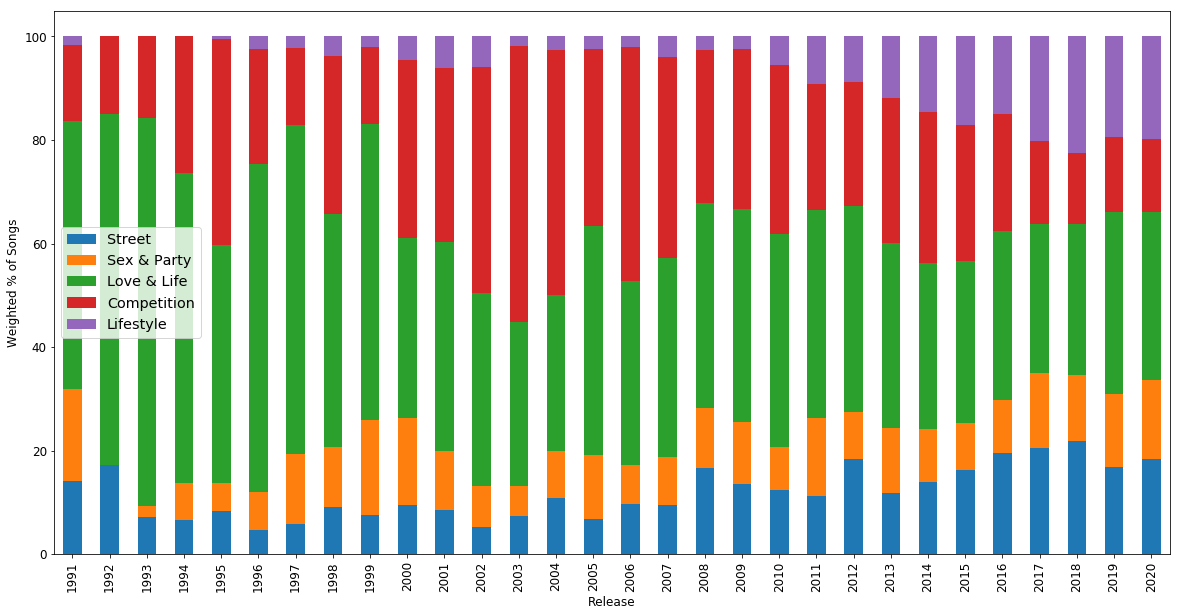

In [410]:
sbr_weighted = all_songs.copy()
weight_strength = math.pow(10, (3/100))
sbr_weighted['Popularity'] = sbr_weighted['Popularity'].map(lambda weight: math.pow(weight_strength, weight))
sbr_weighted['Street'] = sbr_weighted['Street']*sbr_weighted['Popularity']
sbr_weighted['Sex & Party'] = sbr_weighted['Sex & Party']*sbr_weighted['Popularity']
sbr_weighted['Love & Life'] = sbr_weighted['Love & Life']*sbr_weighted['Popularity']
sbr_weighted['Competition'] = sbr_weighted['Competition']*sbr_weighted['Popularity']
sbr_weighted['Lifestyle'] = sbr_weighted['Lifestyle']*sbr_weighted['Popularity']
sbr_weighted = sbr_weighted.groupby(['Release']).mean()
sbr_weighted = sbr_weighted.drop(['0001','1980', '2021'])
sbr_weighted = sbr_weighted.drop(columns=['Label', 'Popularity'])

for idx, row in sbr_weighted.iterrows():
    row = row.copy()
    sbr_weighted.loc[idx] = row/sum(row)*100
    
ax = sbr_weighted.plot.bar(stacked=True)
ax.set_ylabel('Weighted % of Songs')
ax.legend(loc='center left', fontsize='large')

In [408]:
#print(all_songs[all_songs['Title'].str.contains(' \(.*?\)')])
x_ = all_songs[all_songs['Artist']=='Kool Savas']
x_[x_['Release']=='2007']
#print(all_songs.iloc[8]['Lyrics'])
#print(all_songs.head())

,Title,Artist,Release,Lyrics,Label,Street,Sex & Party,Love & Life,Competition,Lifestyle,Popularity
4414,Alle schieben Optik,Kool Savas,2007,": Hey Hey Entschuldigung, Savas ja was is mit ...",3,0.027244,0.071320,0.153130,0.741678,0.000000,39
4440,Der Beweis,Kool Savas,2007,"Ihr wolltet mir nicht glauben, als ich meinte...",3,0.033339,0.067731,0.431136,0.464456,0.000000,43
4457,Essah,Kool Savas,2007,"Meine Damen und Herrn Essah, Essah Ich präse...",3,0.000000,0.042629,0.378326,0.567460,0.000000,38
4490,Krank,Kool Savas,2007,Wir sind krank und ich mein' nicht den Rap au...,2,0.124494,0.000000,0.820615,0.050762,0.000000,28
4507,Melodie,Kool Savas,2007,"Ich weiß, sie wünschen sich, ich würde einfac...",2,0.012346,0.153492,0.599051,0.191595,0.043515,27
4509,Mona Lisa,Kool Savas,2007,"Ich komm' auf die Bühne, leg' Hand ans Mic Fa...",3,0.163386,0.063283,0.207392,0.562814,0.000000,43
4520,Nur ein Spiel,Kool Savas,2007,"Ich kann nicht nochmal reseten, mein Leben zu...",2,0.153779,0.038134,0.427853,0.376897,0.000000,28
4524,On Top,Kool Savas,2007,"Du bist on Top, my man Du hast einfach, was ...",2,0.093105,0.000000,0.823115,0.078316,0.000000,33
4528,Orakel,Kool Savas,2007,"Guck dich an, du bist nicht wirklich mehr als...",2,0.122989,0.020668,0.483201,0.369796,0.000000,27
4556,Tot oder Lebendig,Kool Savas,2007,Dieser Rhyme hier entsteht grad auf 'ner Sour...,2,0.058218,0.073746,0.579085,0.285998,0.000000,43
